# **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




## **Librerie**


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import List, Tuple

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import clone

from skimage.feature import hog, local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from torchvision import datasets

## **Configurazione + Device**

In [13]:
@dataclass
class Config:
    # paths
    data_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset"
    #data_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset"
    fit_dir  = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid"
    #fit_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/valid"
    test_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato"
    #test_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/test_degradato"
    cache_dir = "/kaggle/working/feat_cache"
    
    img_size = 128   # per HOG spesso 128 va benissimo
    use_preprocess = True  # GrayWorld + AutoContrast

    # tuning
    test_size_internal = 0.2
    random_state = 42
    C_grid = (0.1, 0.3, 1.0, 3.0, 10.0)
    max_iter = 50000

def sanity_check_paths(cfg: Config):
    for p in [cfg.data_dir, cfg.fit_dir, cfg.test_dir]:
        if not os.path.exists(p):
            raise FileNotFoundError(f"Path not found: {p}")
    print("OK paths")
    print("fit_dir:", cfg.fit_dir)
    print("test_dir:", cfg.test_dir)

In [14]:

def ensure_cache_dir(cfg):
    os.makedirs(cfg.cache_dir, exist_ok=True)

def feature_signature(cfg, mode: str) -> str:
    # se cambi questi parametri, cambia anche il nome file => niente mismatch
    return f"{mode}_img{cfg.img_size}_pre{int(cfg.use_preprocess)}"

def cache_paths(cfg, mode: str):
    sig = feature_signature(cfg, mode)
    fit_path  = os.path.join(cfg.cache_dir, f"Xy_fit_{sig}.npz")
    test_path = os.path.join(cfg.cache_dir, f"Xy_test_{sig}.npz")
    return fit_path, test_path

def load_xy_npz(path: str):
    data = np.load(path)
    return data["X"], data["y"]

def save_xy_npz(path: str, X: np.ndarray, y: np.ndarray):
    np.savez_compressed(path, X=X, y=y)

## **Preprocessing**

In [15]:
class GrayWorldWB:
    def __call__(self, img: Image.Image) -> Image.Image:
        arr = np.asarray(img).astype(np.float32)
        mean = arr.mean(axis=(0, 1), keepdims=True)
        arr = arr / (mean + 1e-6)
        arr = arr / (arr.max() + 1e-6)
        return Image.fromarray((arr * 255).astype(np.uint8))

class AutoContrast:
    def __call__(self, img: Image.Image) -> Image.Image:
        return ImageOps.autocontrast(img, cutoff=1)

def preprocess_pil(img: Image.Image, cfg: Config) -> Image.Image:
    if cfg.use_preprocess:
        img = GrayWorldWB()(img)
        img = AutoContrast()(img)
    return img

## **Feature Extraction**

In [16]:
def feat_hog(path: str, cfg: Config) -> np.ndarray:
    img = Image.open(path).convert("RGB")
    img = preprocess_pil(img, cfg)
    img = img.resize((cfg.img_size, cfg.img_size))
    img_gray = np.array(img.convert("L"))

    return hog(
        img_gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        feature_vector=True
    ).astype(np.float32)

def feat_lbp(path: str, cfg: Config, P: int = 8, R: int = 1) -> np.ndarray:
    img = Image.open(path).convert("RGB")
    img = preprocess_pil(img, cfg)
    img = img.resize((cfg.img_size, cfg.img_size))
    img_gray = np.array(img.convert("L"))

    lbp = local_binary_pattern(img_gray, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-8)
    return hist

def feat_hog_lbp(path: str, cfg: Config) -> np.ndarray:
    return np.concatenate([feat_hog(path, cfg), feat_lbp(path, cfg)], axis=0)

## **Dataset**

In [17]:
def build_xy(folder: datasets.ImageFolder, cfg: Config, mode: str) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for path, label in folder.samples:
        if mode == "hog":
            X.append(feat_hog(path, cfg))
        elif mode == "lbp":
            X.append(feat_lbp(path, cfg))
        elif mode == "hog+lbp":
            X.append(feat_hog_lbp(path, cfg))
        else:
            raise ValueError("mode must be: 'hog', 'lbp', 'hog+lbp'")
        y.append(label)
    return np.asarray(X), np.asarray(y)

## **Evaluation su test + Matrice di confusione**

In [18]:
def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix (normalized)"):
    cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    plt.figure(figsize=(18, 16))
    sns.heatmap(cm_norm, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


def print_top_confusions(cm: np.ndarray, class_names: List[str], top_k: int = 100):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                pairs.append((i, j, cm_no_diag[i, j]))

    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_k} coppie più confuse:\n")
    for i, j, value in pairs_sorted[:top_k]:
        print(f"{class_names[i]} → {class_names[j]}  | {value} errori")

def tune_and_test_model(X_fit, y_fit, X_test, y_test, cfg: Config, model_name: str, base_pipe: Pipeline, param_grid: dict):
    # split interno sul VALID
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_fit, y_fit,
        test_size=cfg.test_size_internal,
        random_state=cfg.random_state,
        stratify=y_fit
    )

    best_params = None
    best_f1 = -1.0
    best_pipe = None

    # grid search manuale (semplice e controllabile)
    # param_grid: dict tipo {"svm__C":[...], "knn__n_neighbors":[...]}
    keys = list(param_grid.keys())
    values = list(param_grid.values())

    def product(lst):
        if not lst:
            return [()]
        out = [()]
        for v in lst:
            out = [x + (y,) for x in out for y in v]
        return out

    for combo in product(values):
        pipe = clone(base_pipe)
        params = {k: combo[i] for i, k in enumerate(keys)}
        pipe.set_params(**params)

        pipe.fit(X_tr, y_tr)
        y_val_pred = pipe.predict(X_val)

        f1 = f1_score(y_val, y_val_pred, average="macro", zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_params = params
            best_pipe = pipe

    # fit finale su TUTTO il VALID
    final_pipe = clone(base_pipe)
    if best_params is not None:
        final_pipe.set_params(**best_params)

    final_pipe.fit(X_fit, y_fit)
    y_pred = final_pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro", zero_division=0)
    cm  = confusion_matrix(y_test, y_pred)

    return best_params, best_f1, acc, f1, cm, final_pipe


def get_or_build_xy(folder, cfg, mode: str, split_name: str):
    """
    split_name: "fit" o "test"
    """
    ensure_cache_dir(cfg)
    fit_path, test_path = cache_paths(cfg, mode)
    path = fit_path if split_name == "fit" else test_path

    if os.path.exists(path):
        print(f"[CACHE HIT] {split_name} {mode} -> {path}")
        return load_xy_npz(path)

    print(f"[CACHE MISS] calcolo feature per {split_name} {mode}...")
    X, y = build_xy(folder, cfg, mode)   # <-- la tua funzione build_xy
    save_xy_npz(path, X, y)
    print(f"[CACHE SAVE] {split_name} {mode} -> {path}")
    return X, y


In [19]:
def get_models(cfg: Config):
    models = {}

    # 1) LinearSVC
    models["LinearSVC"] = (
        Pipeline([("scaler", StandardScaler()), ("clf", LinearSVC(max_iter=cfg.max_iter))]),
        {"clf__C": list(cfg.C_grid)}
    )

    # 2) Logistic Regression (multiclasse)
    models["LogReg"] = (
        Pipeline([("scaler", StandardScaler()),
                  ("clf", LogisticRegression(max_iter=5000, n_jobs=-1, multi_class="auto"))]),
        {"clf__C": [0.1, 0.3, 1.0, 3.0, 10.0]}
    )

    # 3) RidgeClassifier (molto veloce)
    models["Ridge"] = (
        Pipeline([("scaler", StandardScaler()),
                  ("clf", RidgeClassifier())]),
        {"clf__alpha": [0.1, 1.0, 3.0, 10.0]}
    )

    # 4) KNN (scale obbligatoria)
    models["KNN"] = (
        Pipeline([("scaler", StandardScaler()),
                  ("clf", KNeighborsClassifier())]),
        {"clf__n_neighbors": [3, 5, 11, 21], "clf__weights": ["uniform", "distance"]}
    )

    # 5) RandomForest (NON serve scaler, ma non fa male tenerlo fuori)
    # Qui faccio pipeline senza scaler
    models["RF"] = (
        Pipeline([("clf", RandomForestClassifier(random_state=cfg.random_state, n_jobs=-1))]),
        {"clf__n_estimators": [200, 500], "clf__max_depth": [None, 20, 40]}
    )

    # 6) Naive Bayes (GaussianNB) – spesso ok su feature dense
    models["GNB"] = (
        Pipeline([("scaler", StandardScaler()),
                  ("clf", GaussianNB())]),
        {}  # niente iperparametri principali
    )

    return models


## **Main**

In [20]:
cfg = Config()
np.random.seed(cfg.random_state)
sanity_check_paths(cfg)

OK paths
fit_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid
test_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato


In [21]:
fit_ds  = datasets.ImageFolder(cfg.fit_dir)   # VALID come training del task3
test_ds = datasets.ImageFolder(cfg.test_dir)

print("Fit classes:", fit_ds.classes)
print("Test classes:", test_ds.classes)
assert fit_ds.classes == test_ds.classes, "ATTENZIONE: class order diverso tra fit e test!"

class_names = fit_ds.classes

Fit classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbi


MODE = hog
[CACHE MISS] calcolo feature per fit hog...
[CACHE SAVE] fit hog -> /kaggle/working/feat_cache/Xy_fit_hog_img128_pre1.npz
[CACHE MISS] calcolo feature per test hog...
[CACHE SAVE] test hog -> /kaggle/working/feat_cache/Xy_test_hog_img128_pre1.npz

--- MODEL = LinearSVC ---
Best params: {'clf__C': 0.1}
Val Macro-F1: 0.0923
TEST Acc:     0.0980
TEST Macro-F1:0.0905


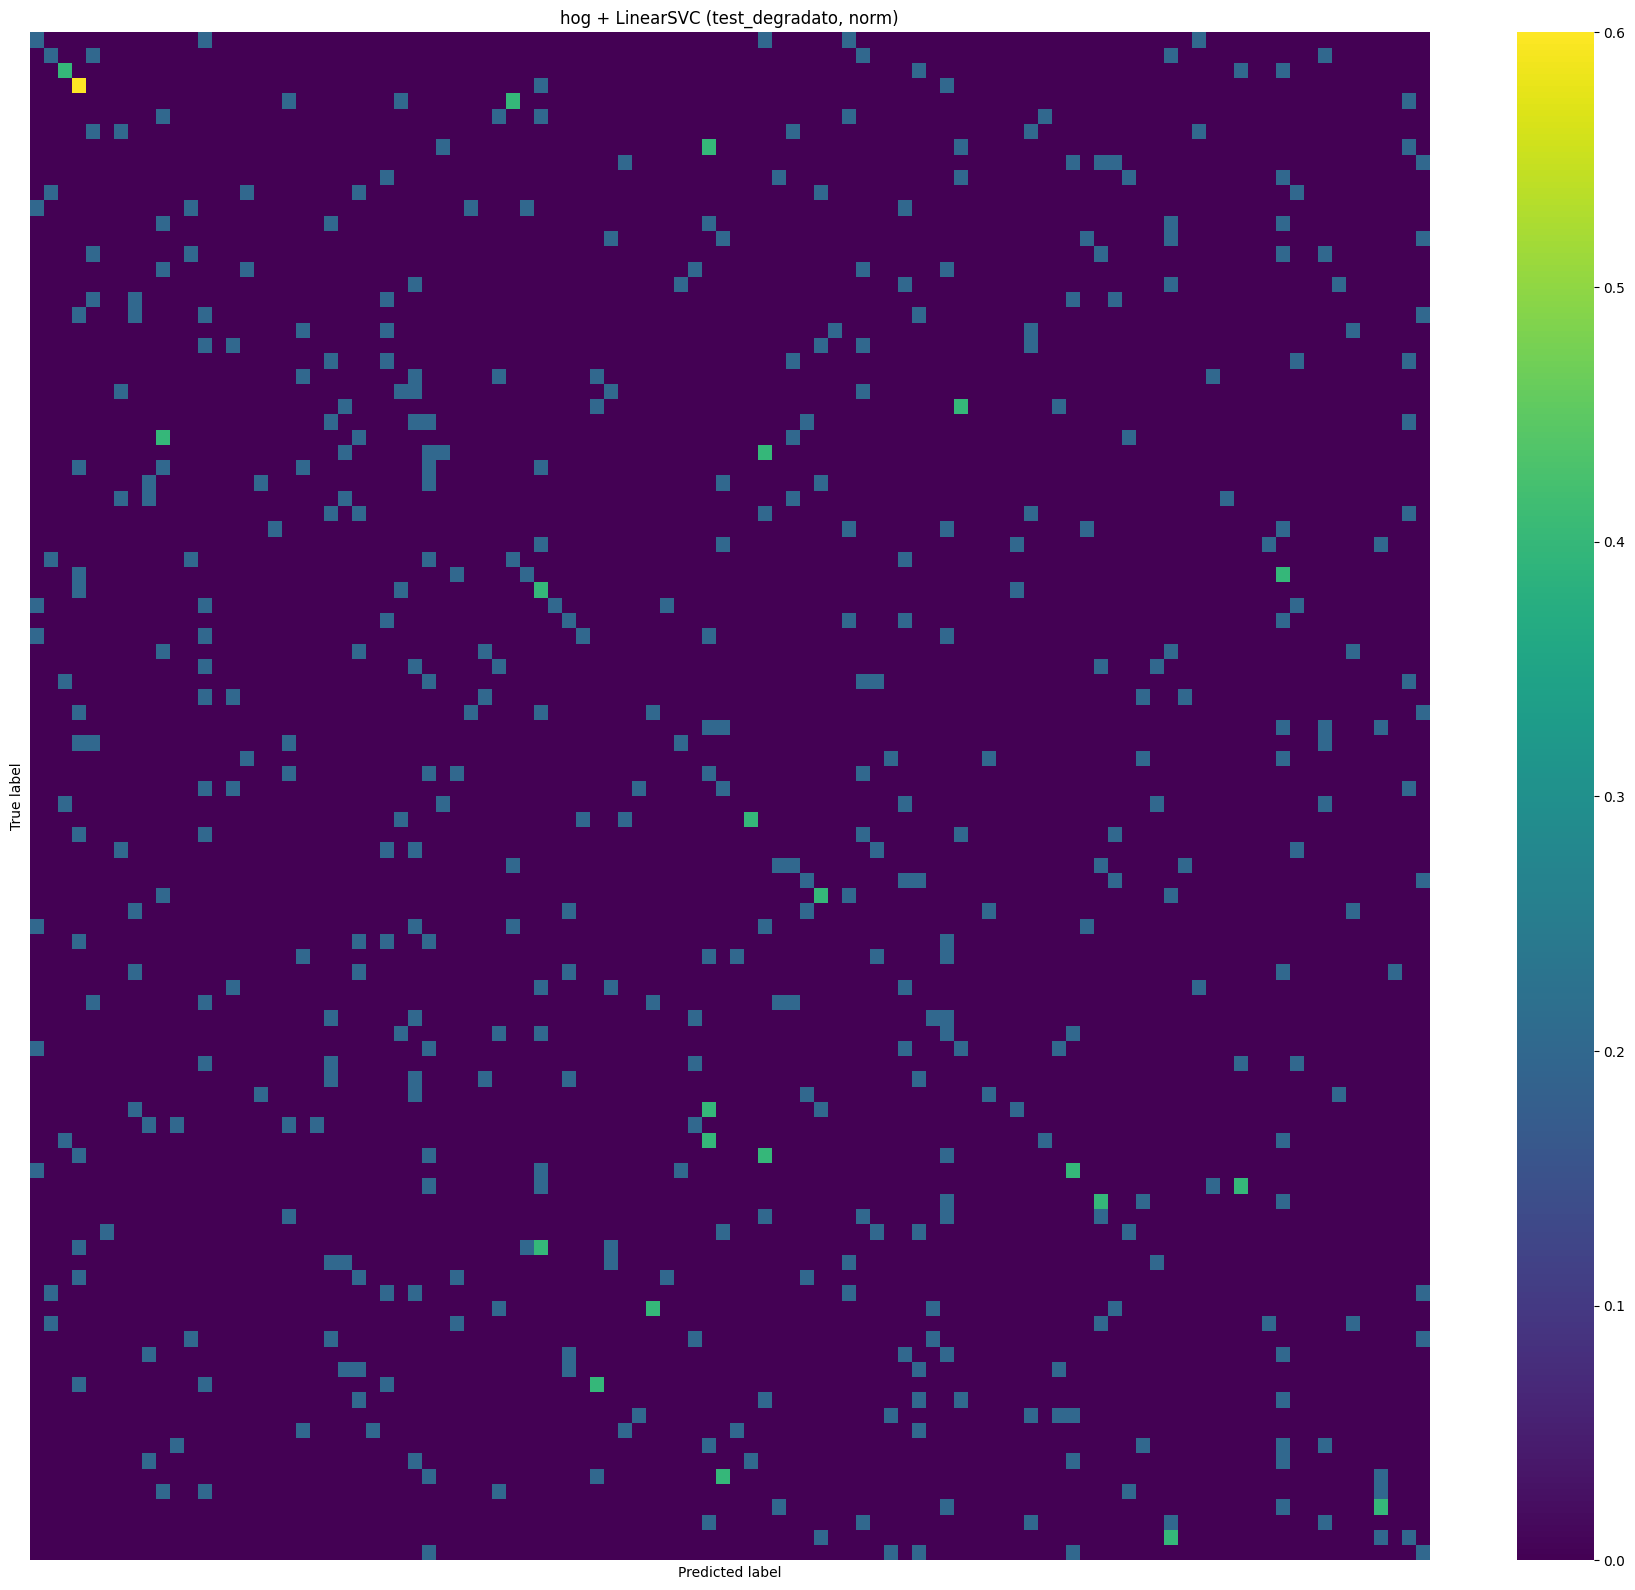


--- MODEL = LogReg ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Best params: {'clf__C': 0.1}
Val Macro-F1: 0.1200
TEST Acc:     0.1500
TEST Macro-F1:0.1476


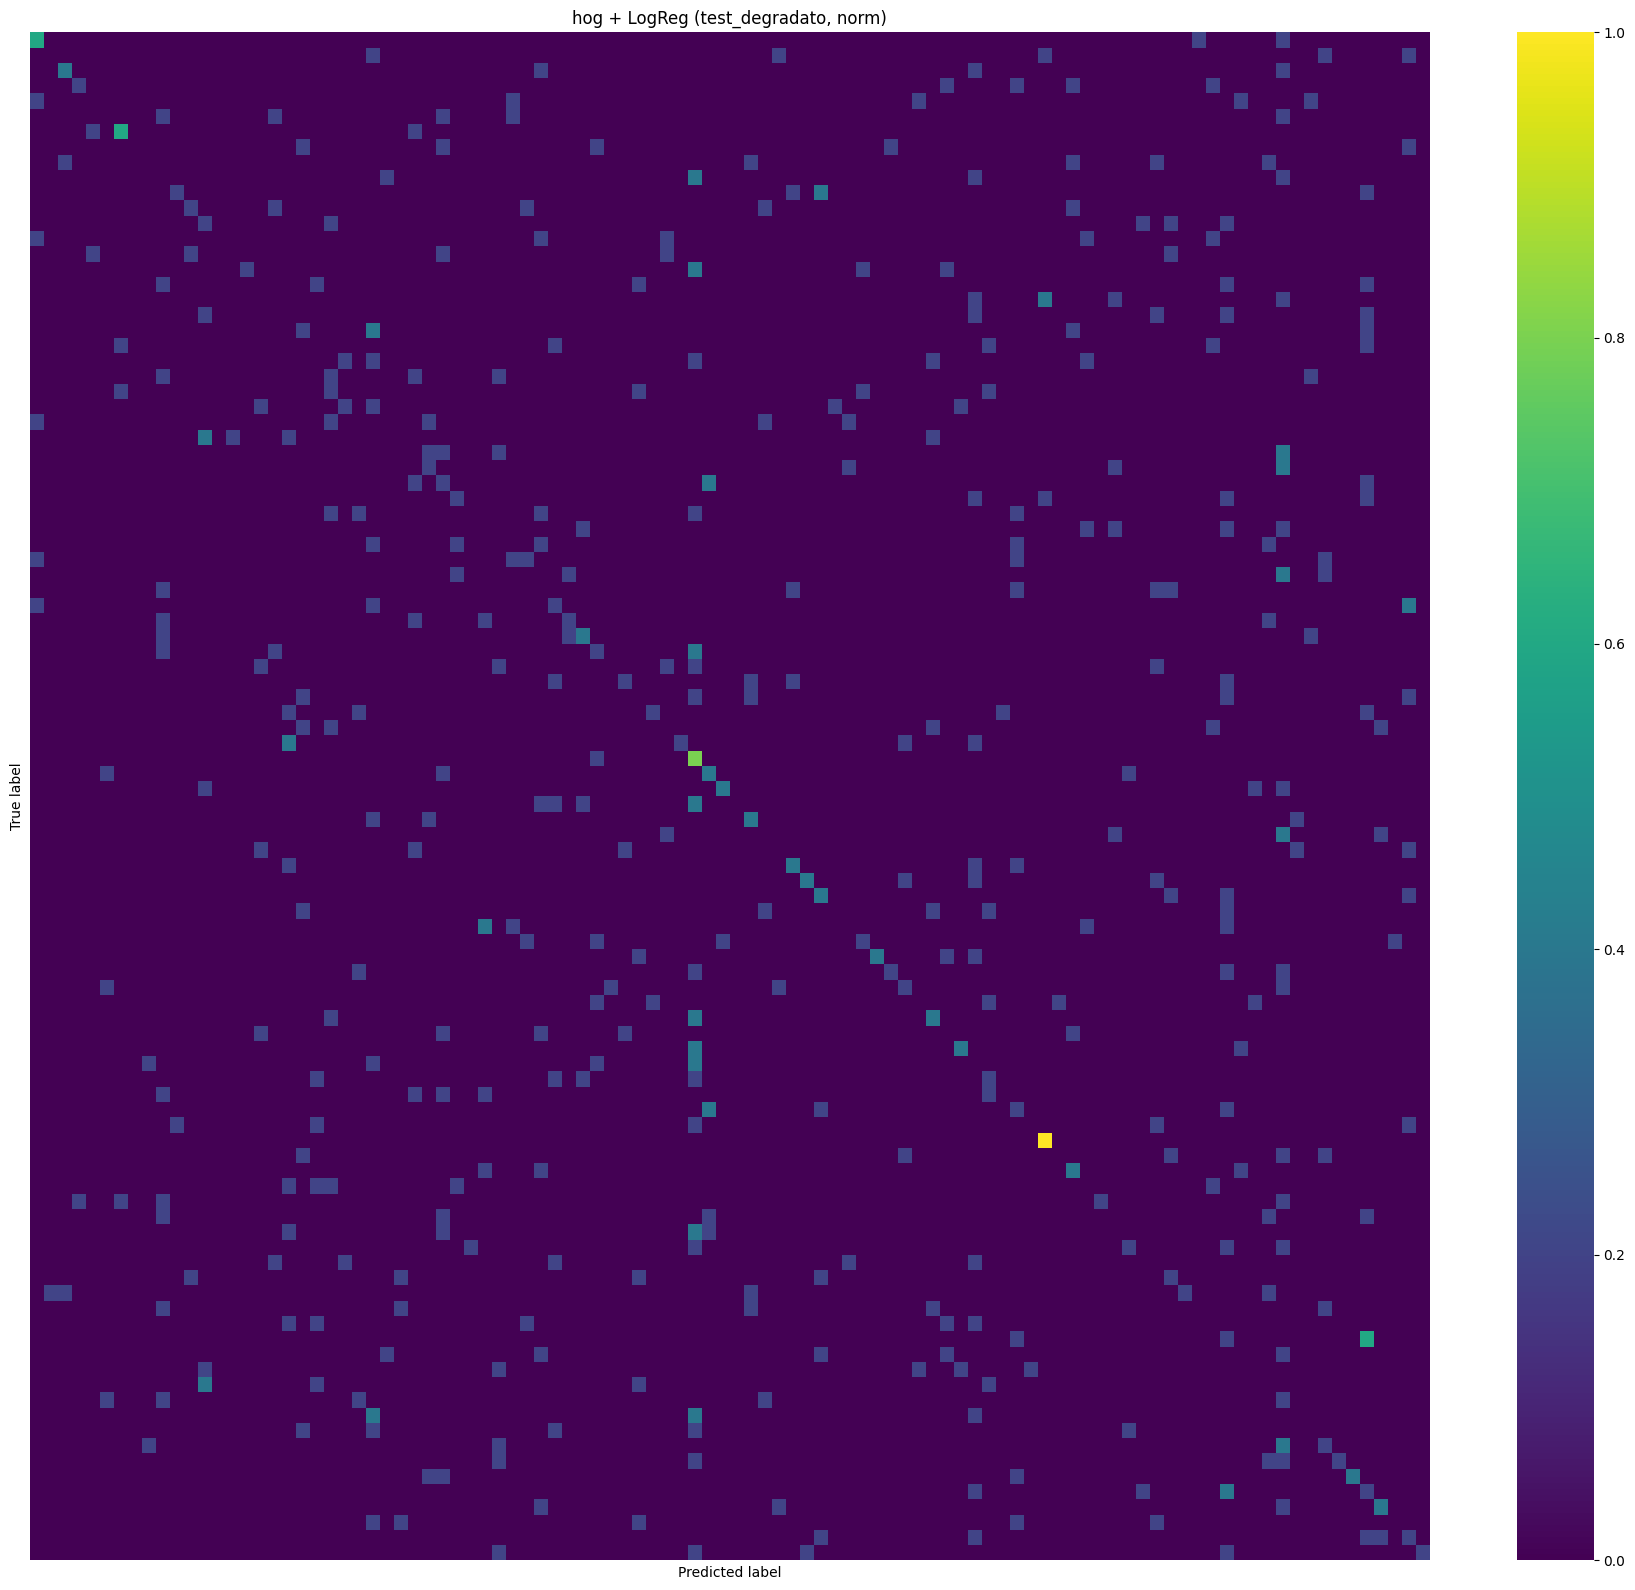


--- MODEL = Ridge ---
Best params: {'clf__alpha': 0.1}
Val Macro-F1: 0.0757
TEST Acc:     0.1020
TEST Macro-F1:0.0970


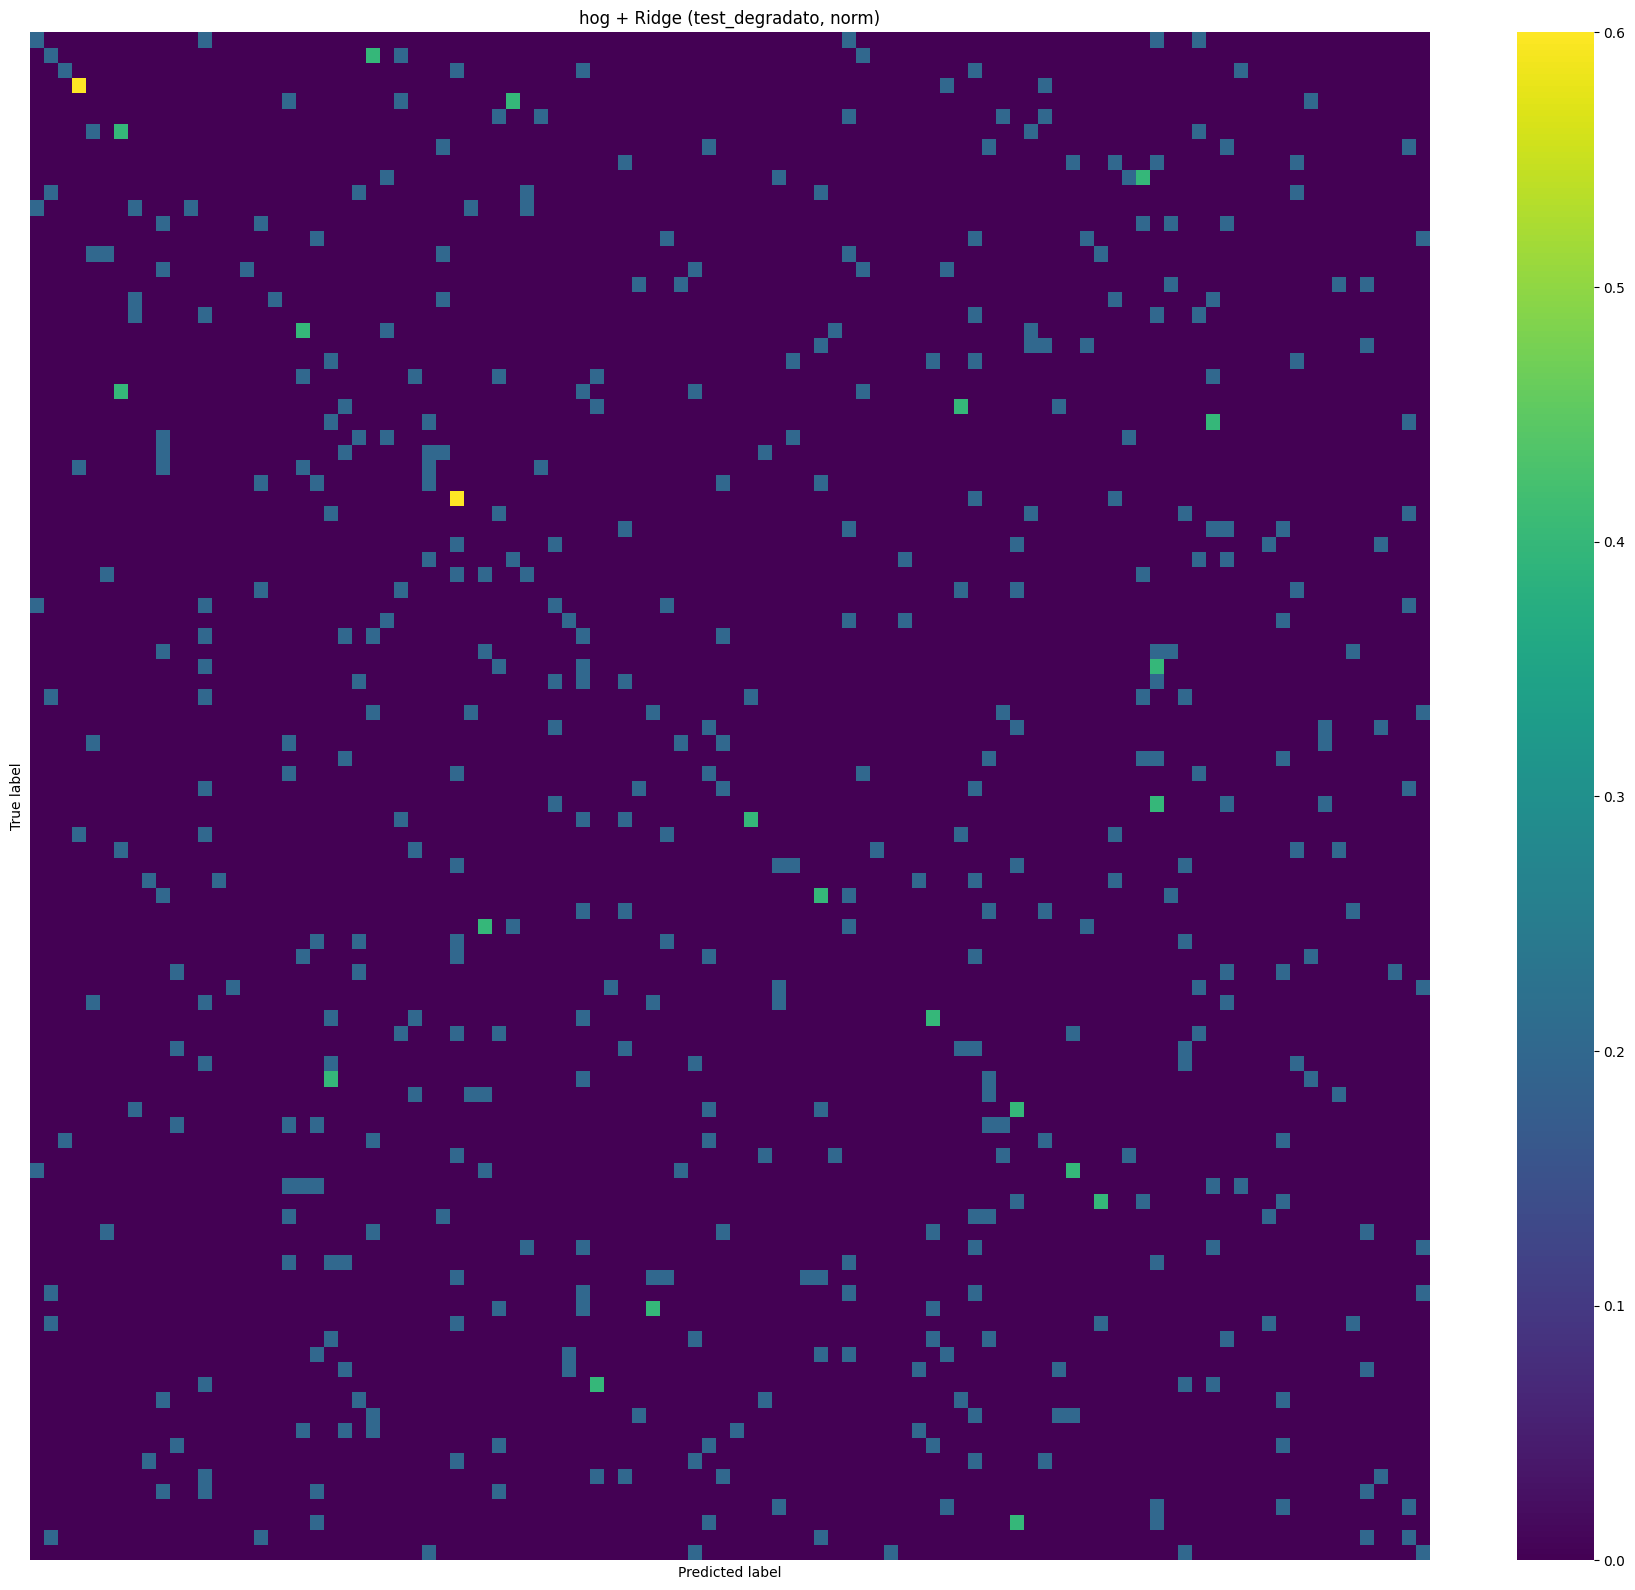


--- MODEL = KNN ---
Best params: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Val Macro-F1: 0.0244
TEST Acc:     0.0540
TEST Macro-F1:0.0371


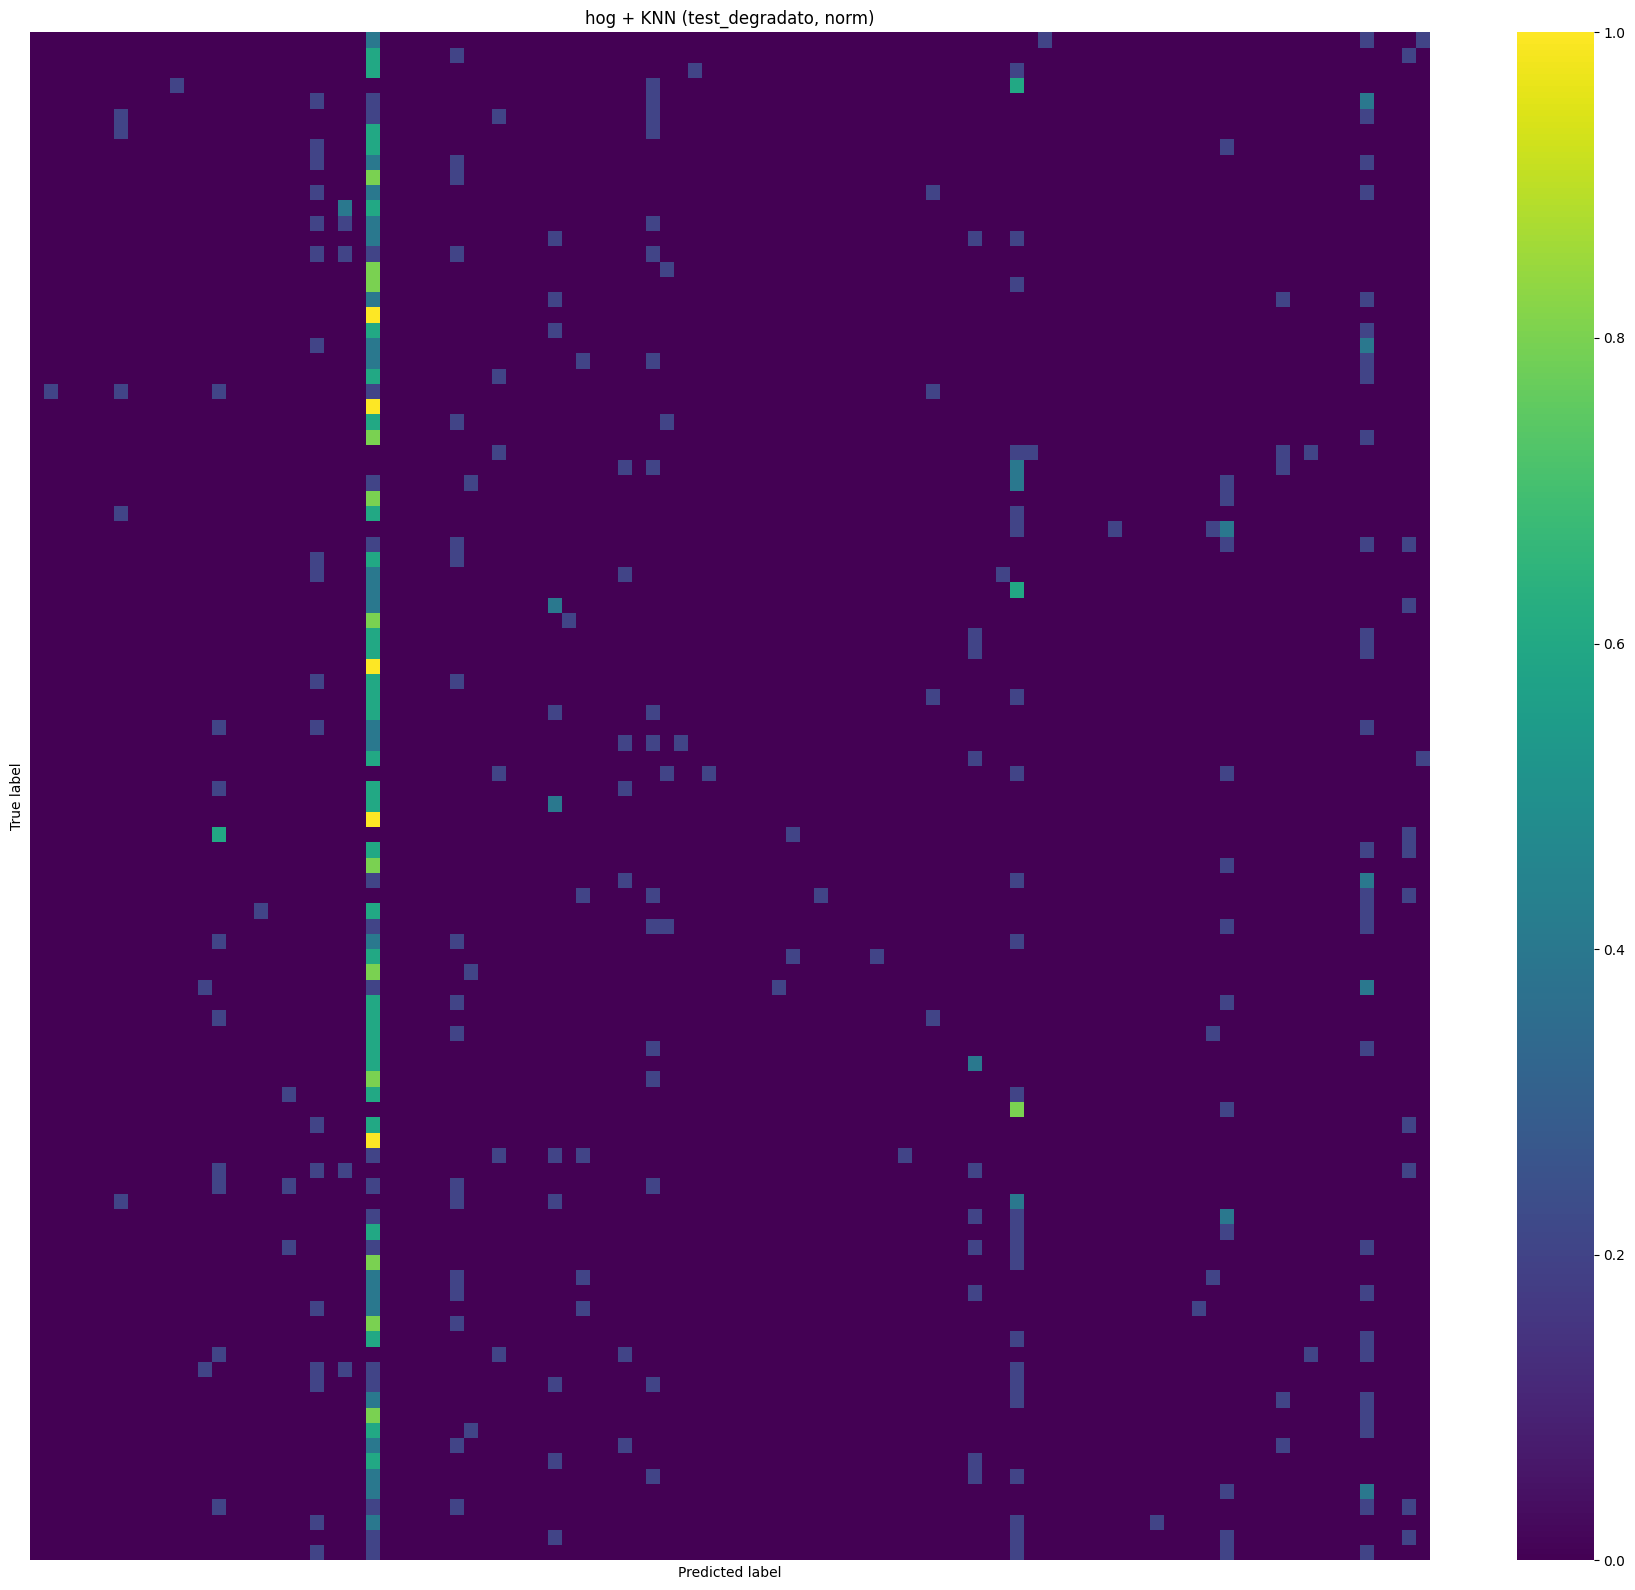


--- MODEL = RF ---
Best params: {'clf__n_estimators': 500, 'clf__max_depth': 40}
Val Macro-F1: 0.0700
TEST Acc:     0.0660
TEST Macro-F1:0.0546


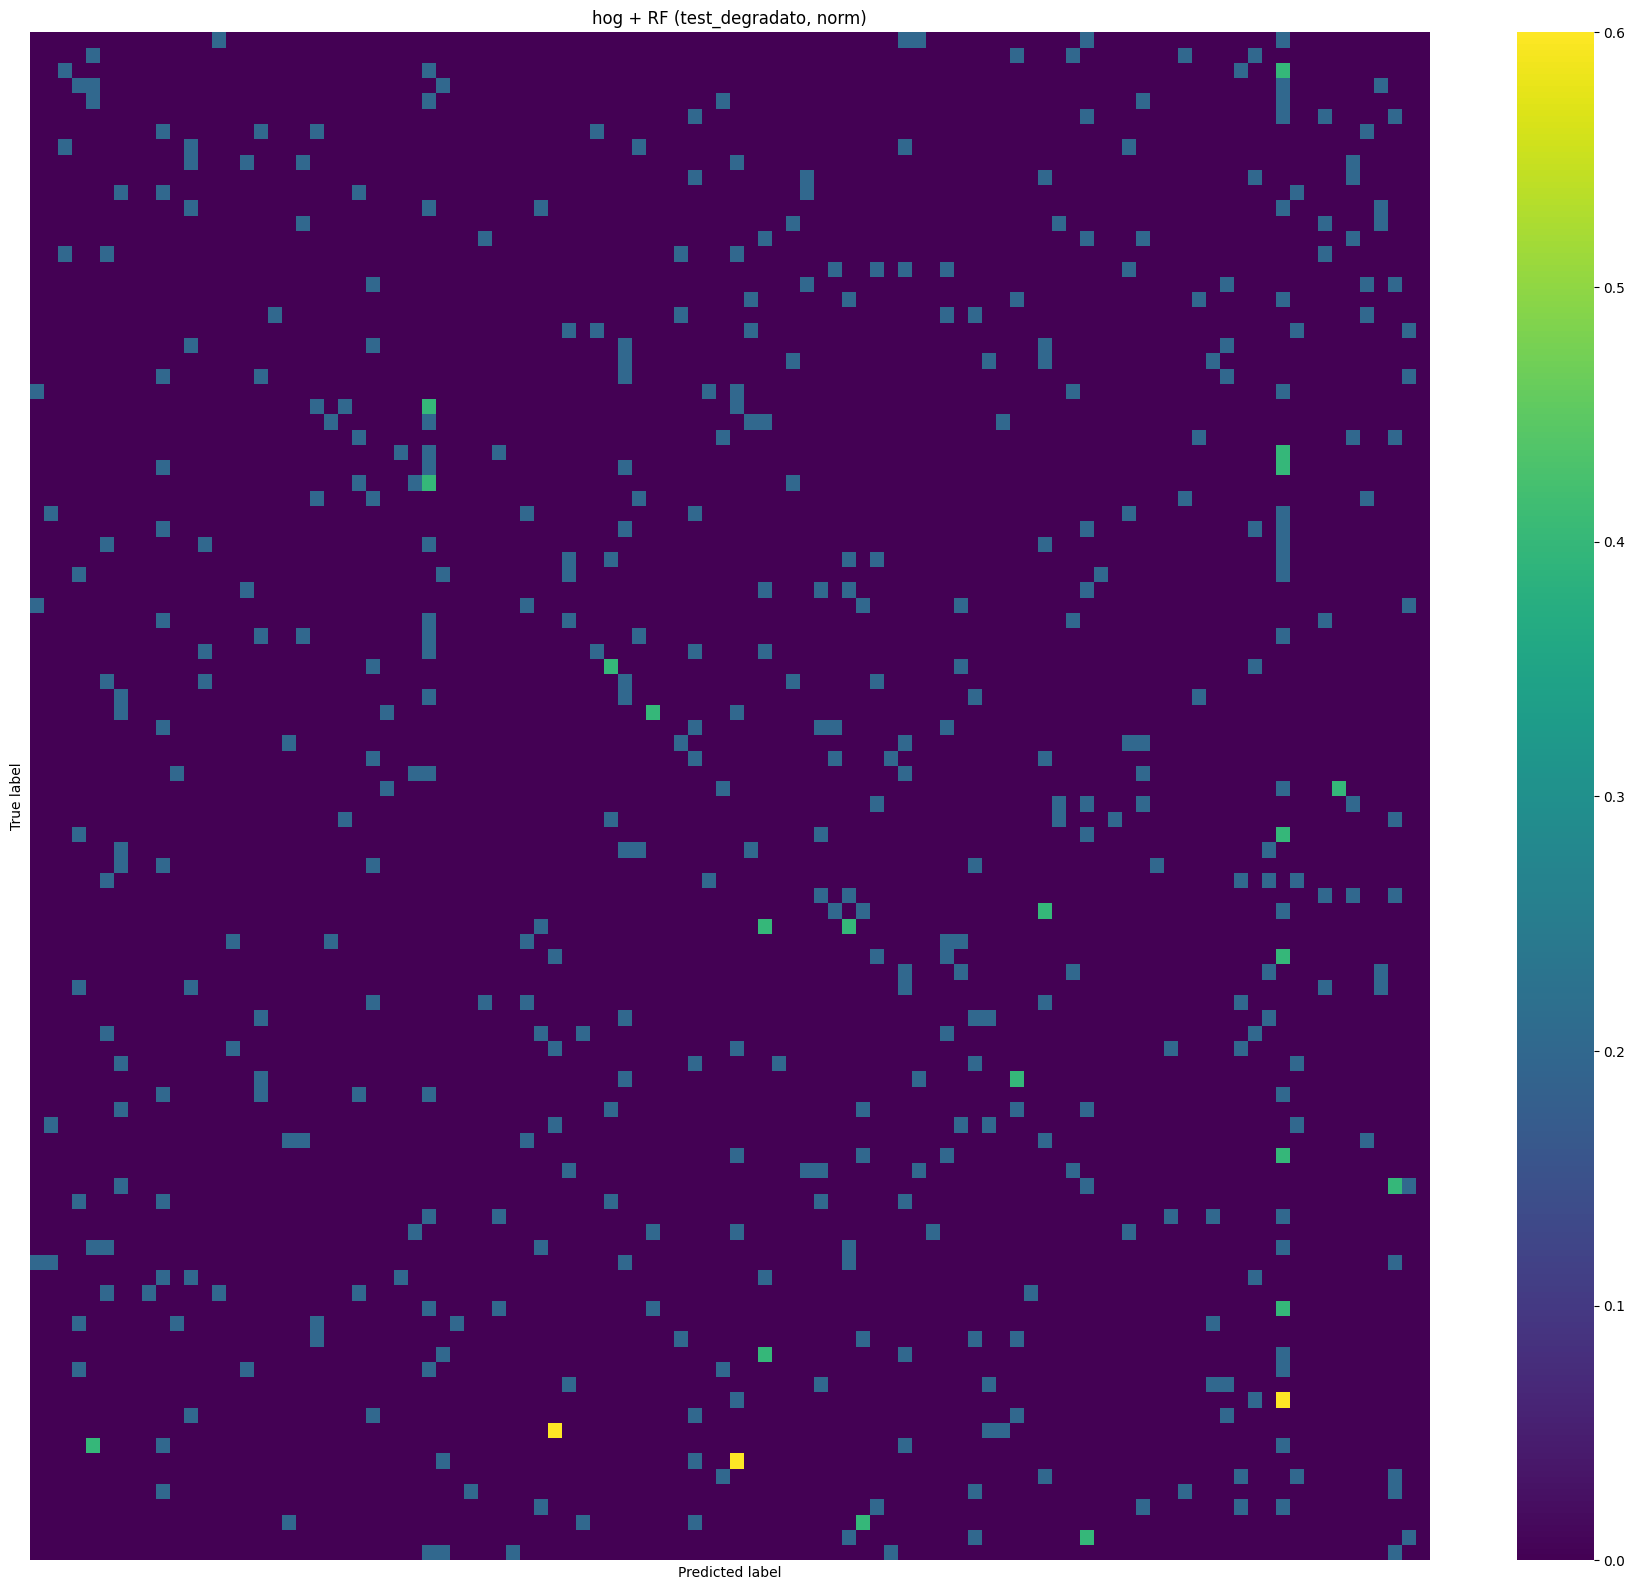


--- MODEL = GNB ---
Best params: {}
Val Macro-F1: 0.0015
TEST Acc:     0.0400
TEST Macro-F1:0.0350


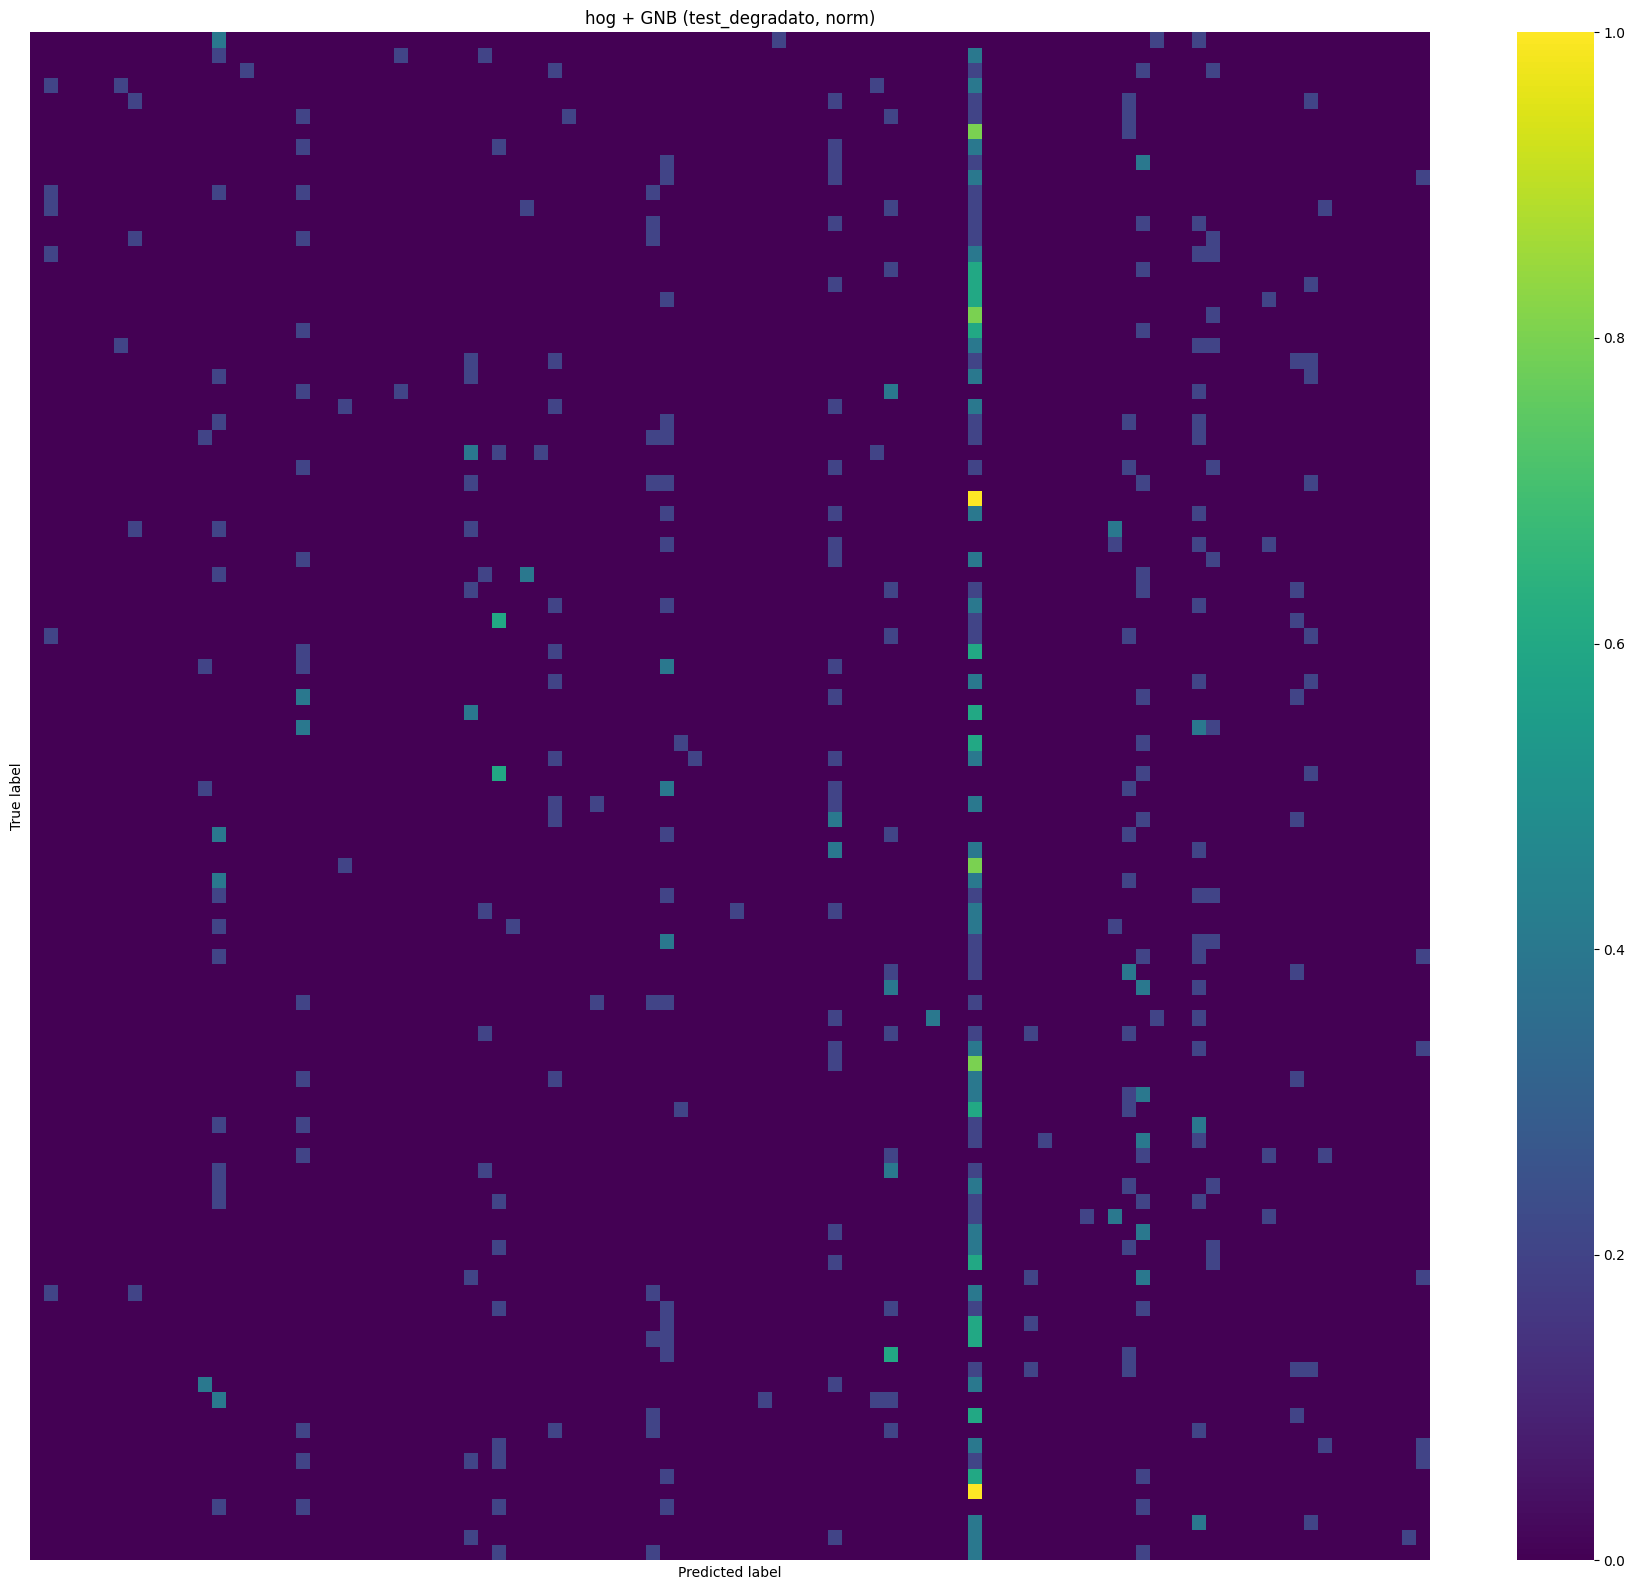


MODE = lbp
[CACHE MISS] calcolo feature per fit lbp...
[CACHE SAVE] fit lbp -> /kaggle/working/feat_cache/Xy_fit_lbp_img128_pre1.npz
[CACHE MISS] calcolo feature per test lbp...
[CACHE SAVE] test lbp -> /kaggle/working/feat_cache/Xy_test_lbp_img128_pre1.npz

--- MODEL = LinearSVC ---
Best params: {'clf__C': 3.0}
Val Macro-F1: 0.0362
TEST Acc:     0.0480
TEST Macro-F1:0.0330


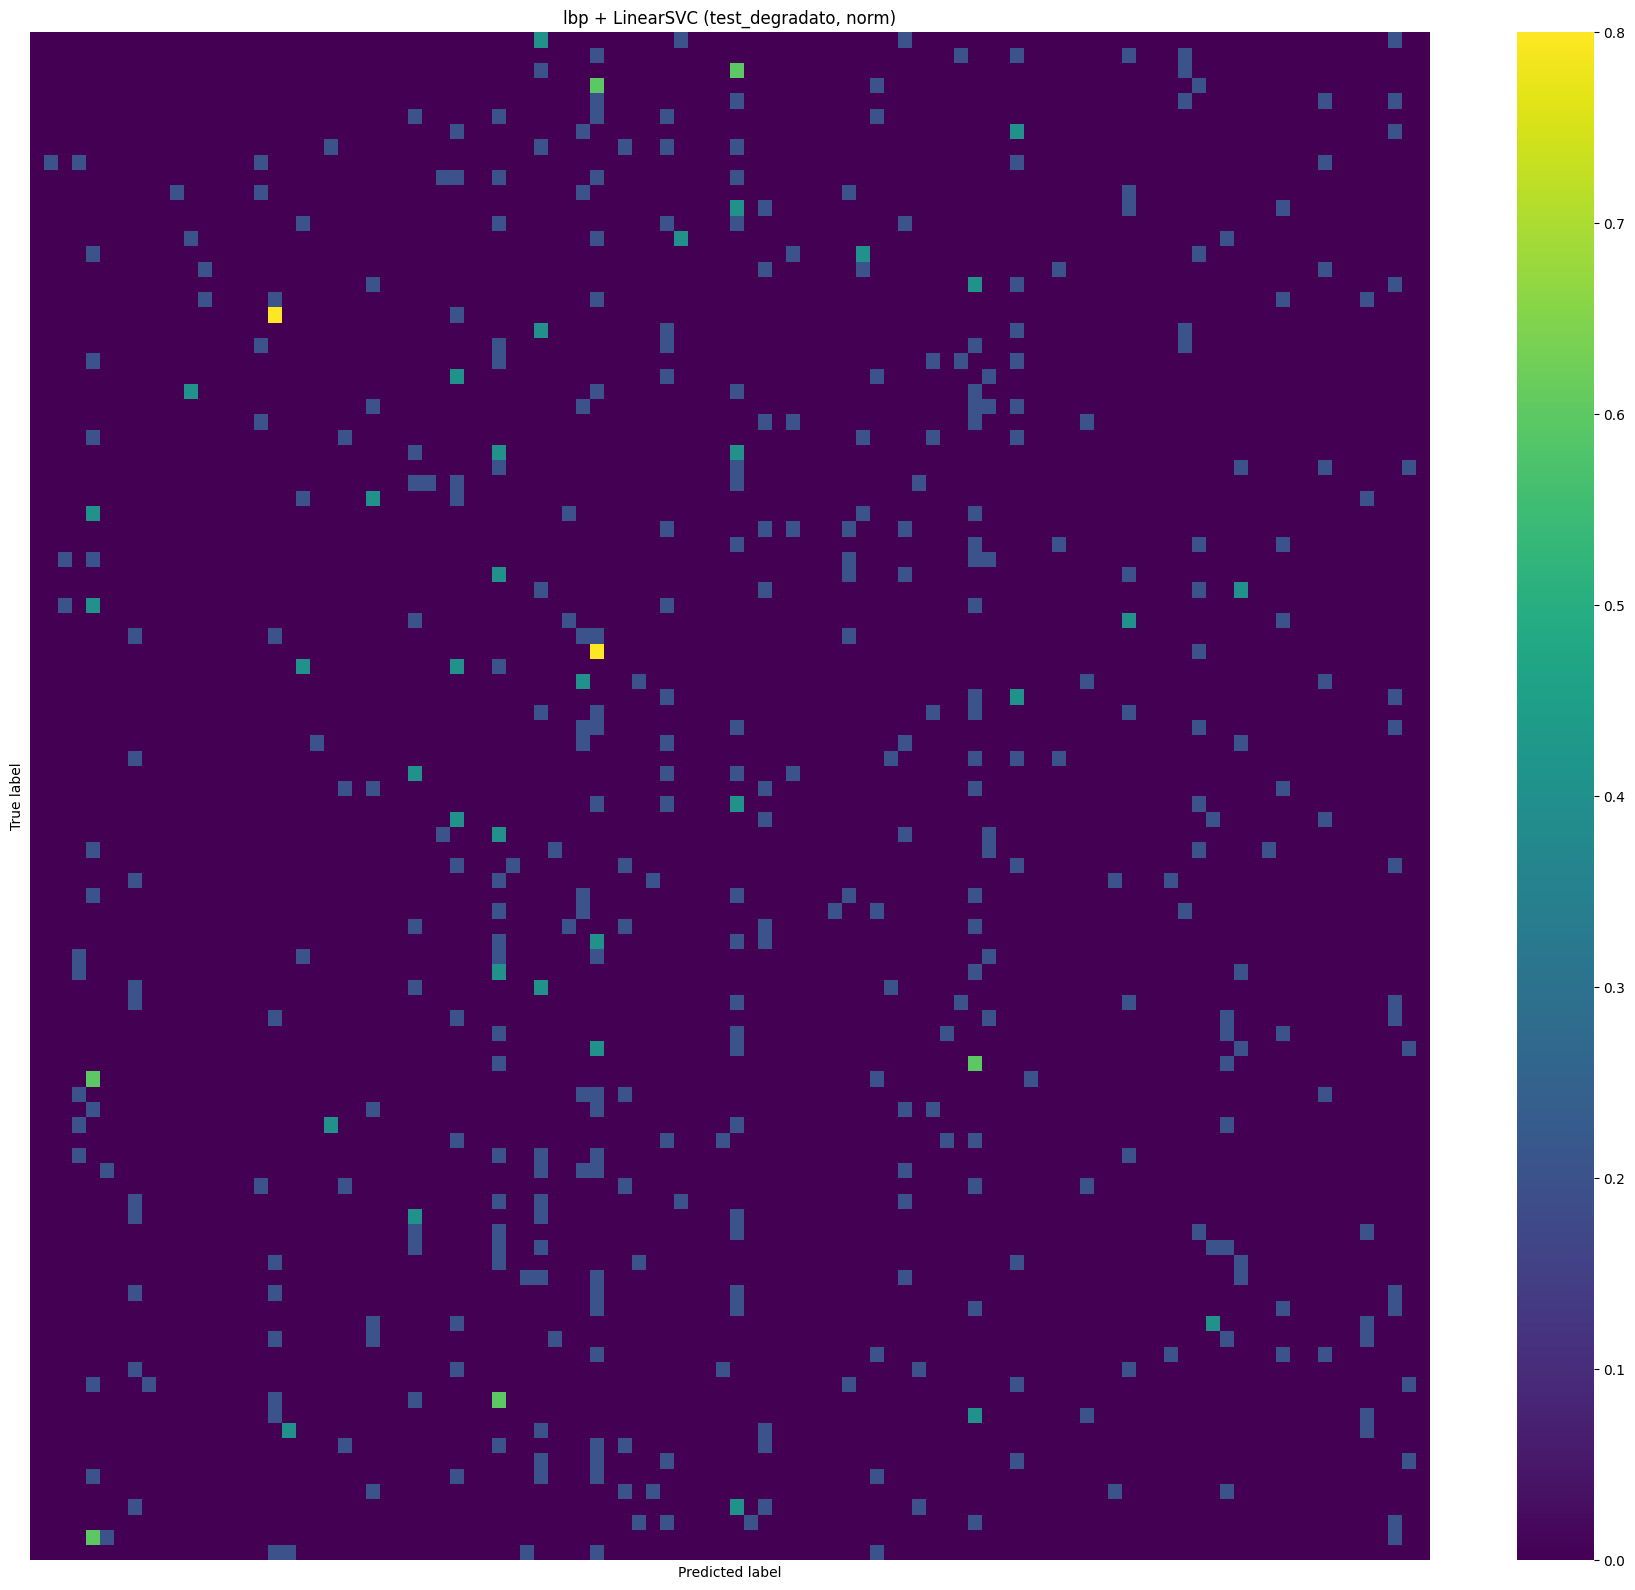


--- MODEL = LogReg ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Best params: {'clf__C': 10.0}
Val Macro-F1: 0.0533
TEST Acc:     0.0560
TEST Macro-F1:0.0485


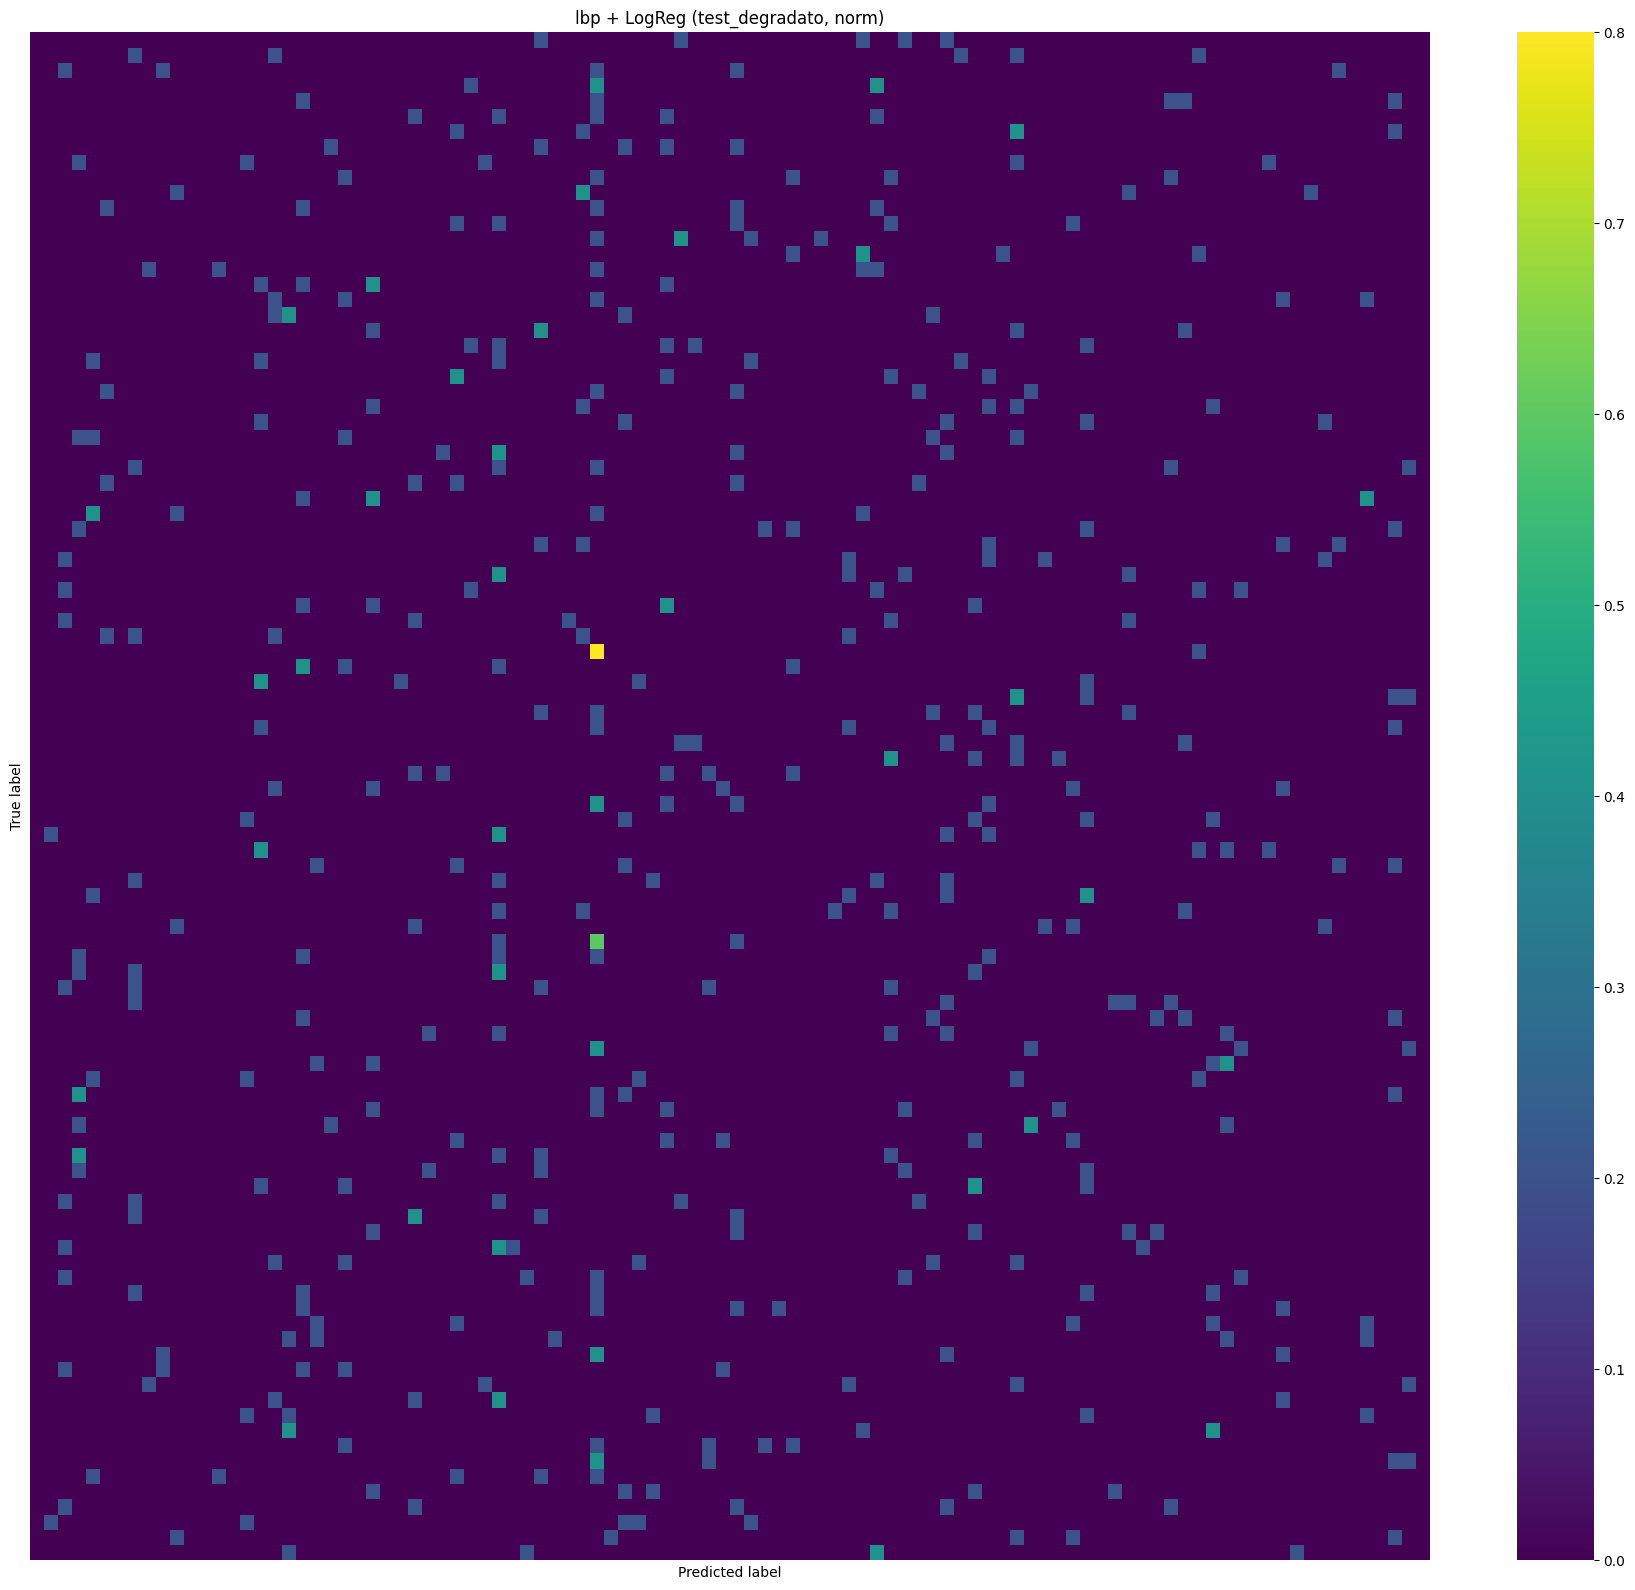


--- MODEL = Ridge ---
Best params: {'clf__alpha': 1.0}
Val Macro-F1: 0.0170
TEST Acc:     0.0440
TEST Macro-F1:0.0207


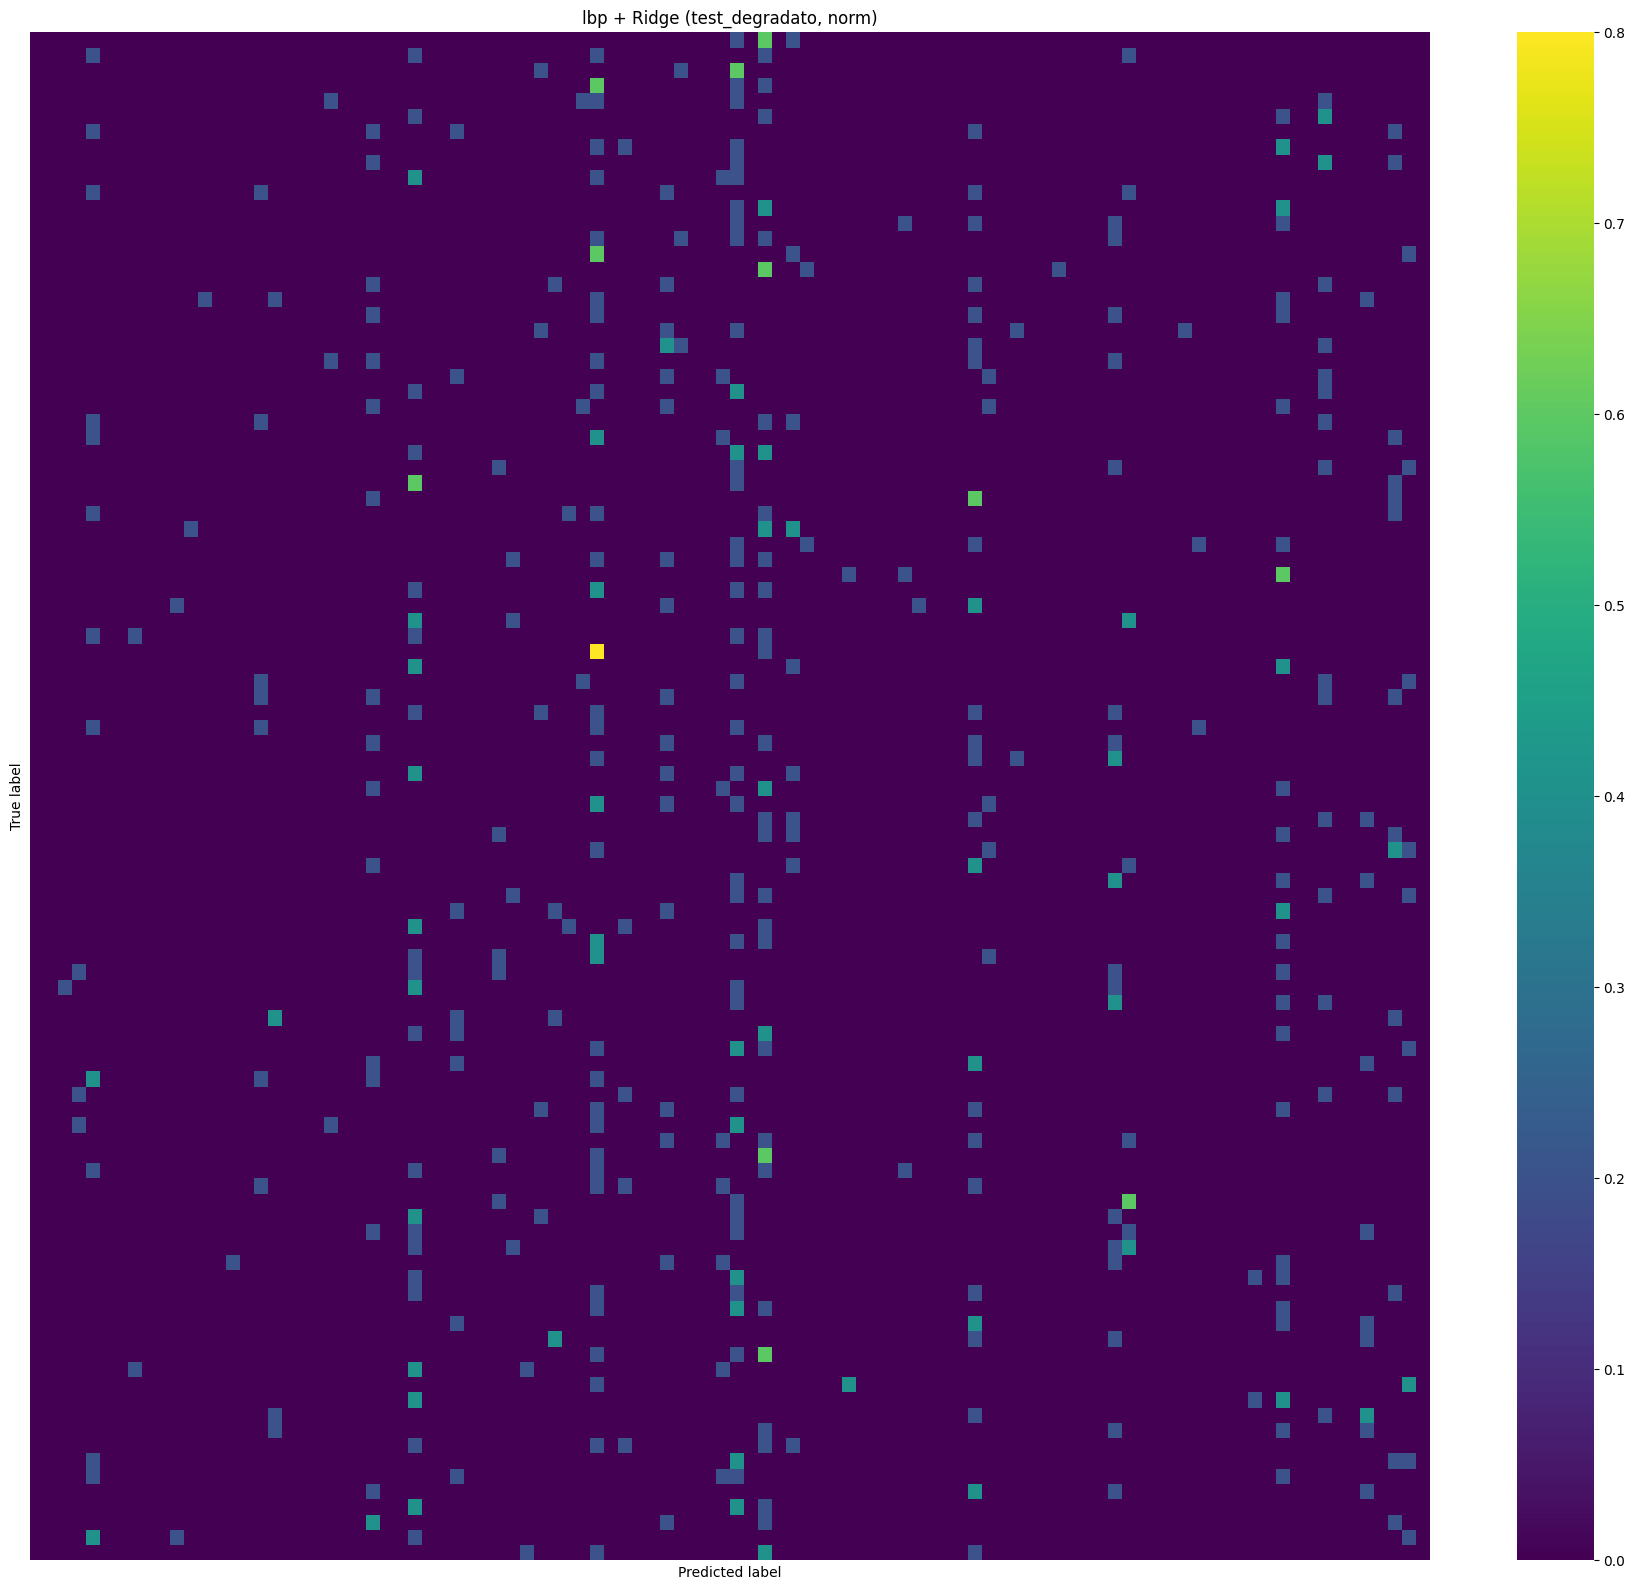


--- MODEL = KNN ---
Best params: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
Val Macro-F1: 0.0600
TEST Acc:     0.0480
TEST Macro-F1:0.0449


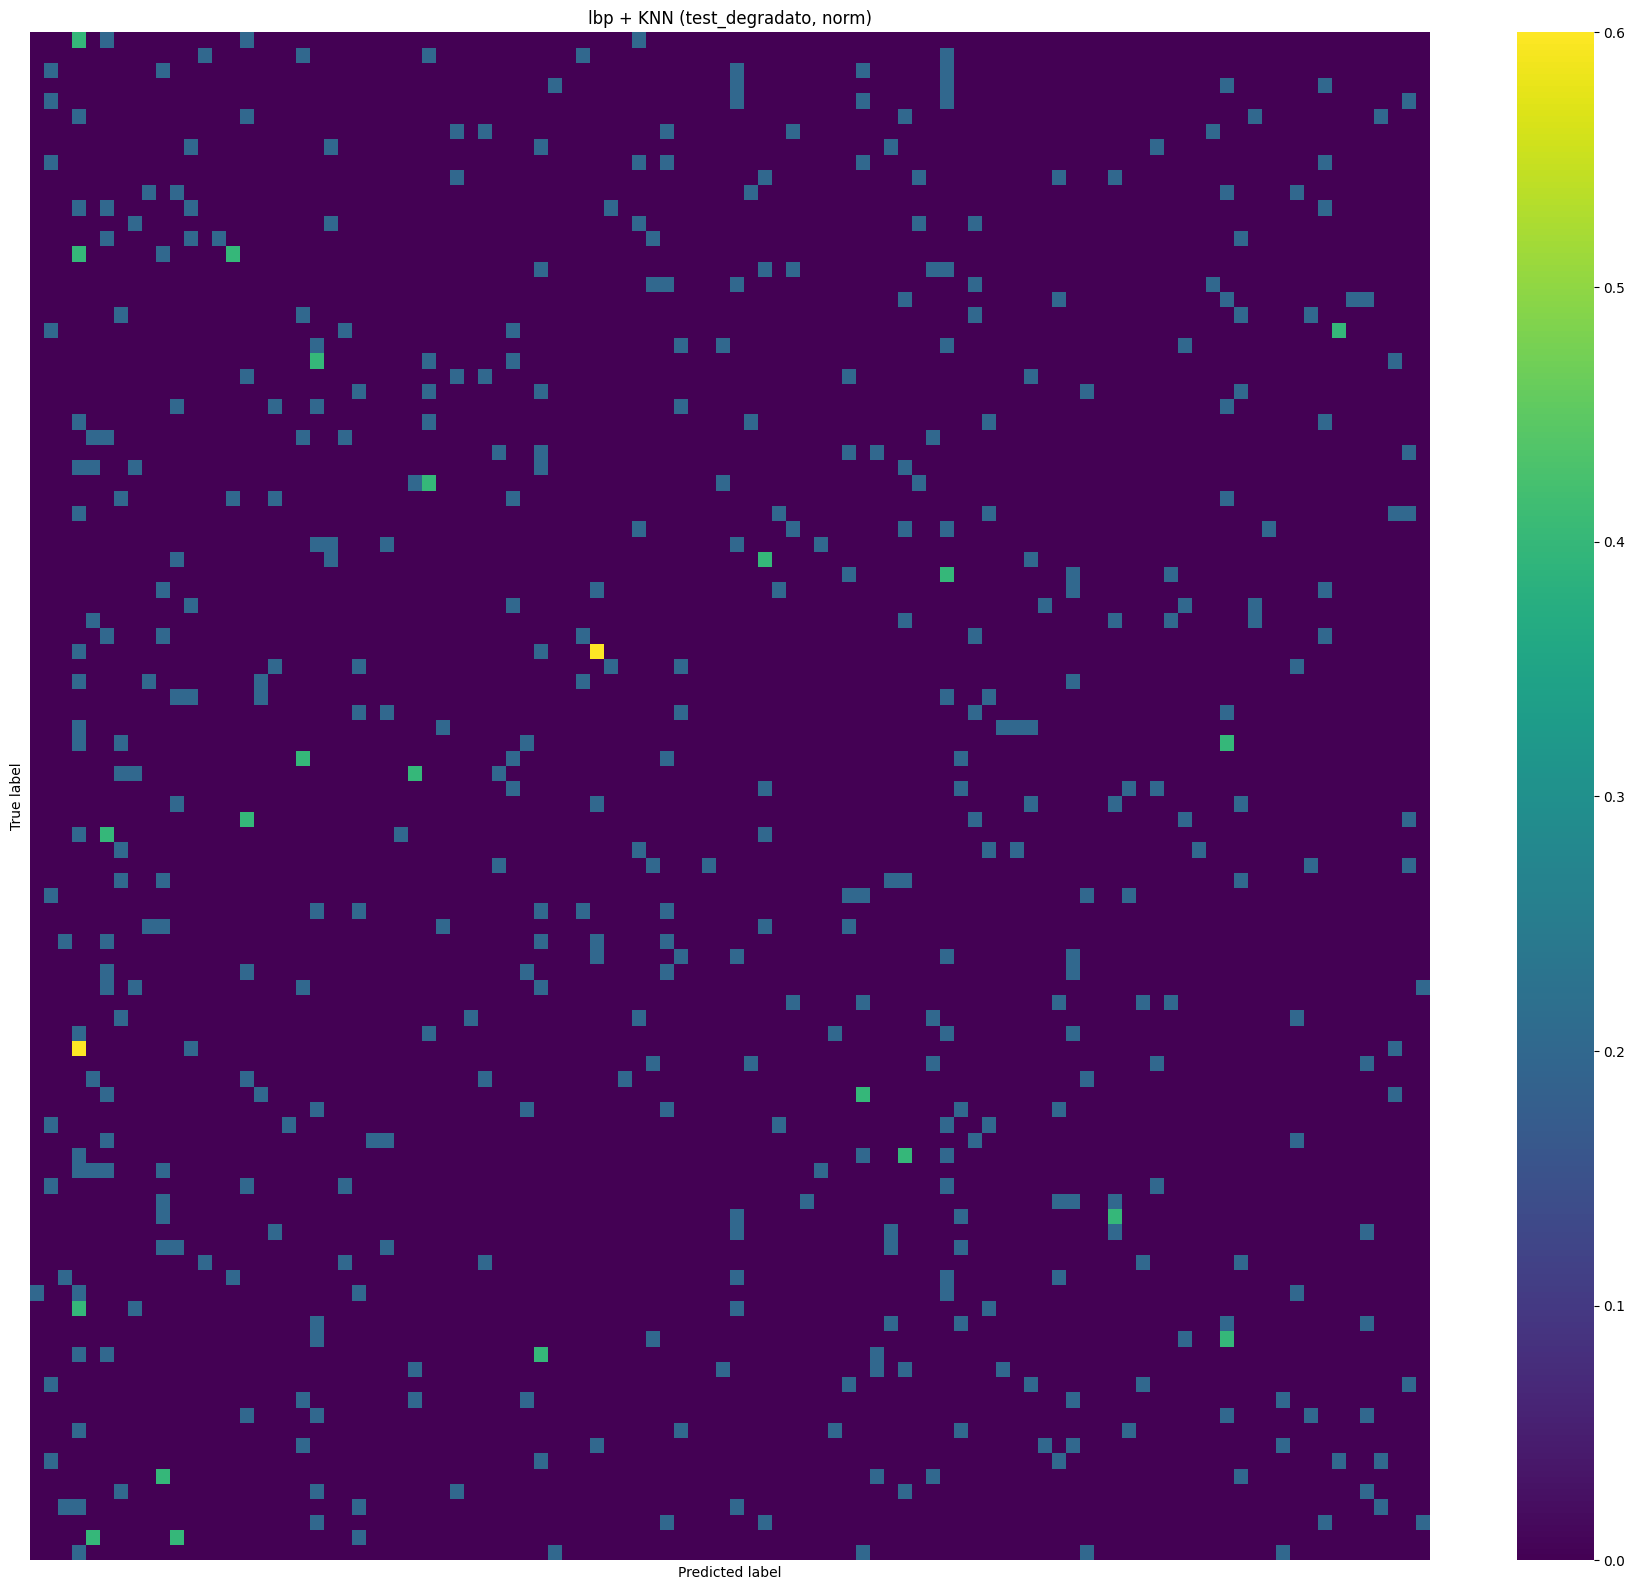


--- MODEL = RF ---
Best params: {'clf__n_estimators': 200, 'clf__max_depth': 20}
Val Macro-F1: 0.0433
TEST Acc:     0.0500
TEST Macro-F1:0.0527


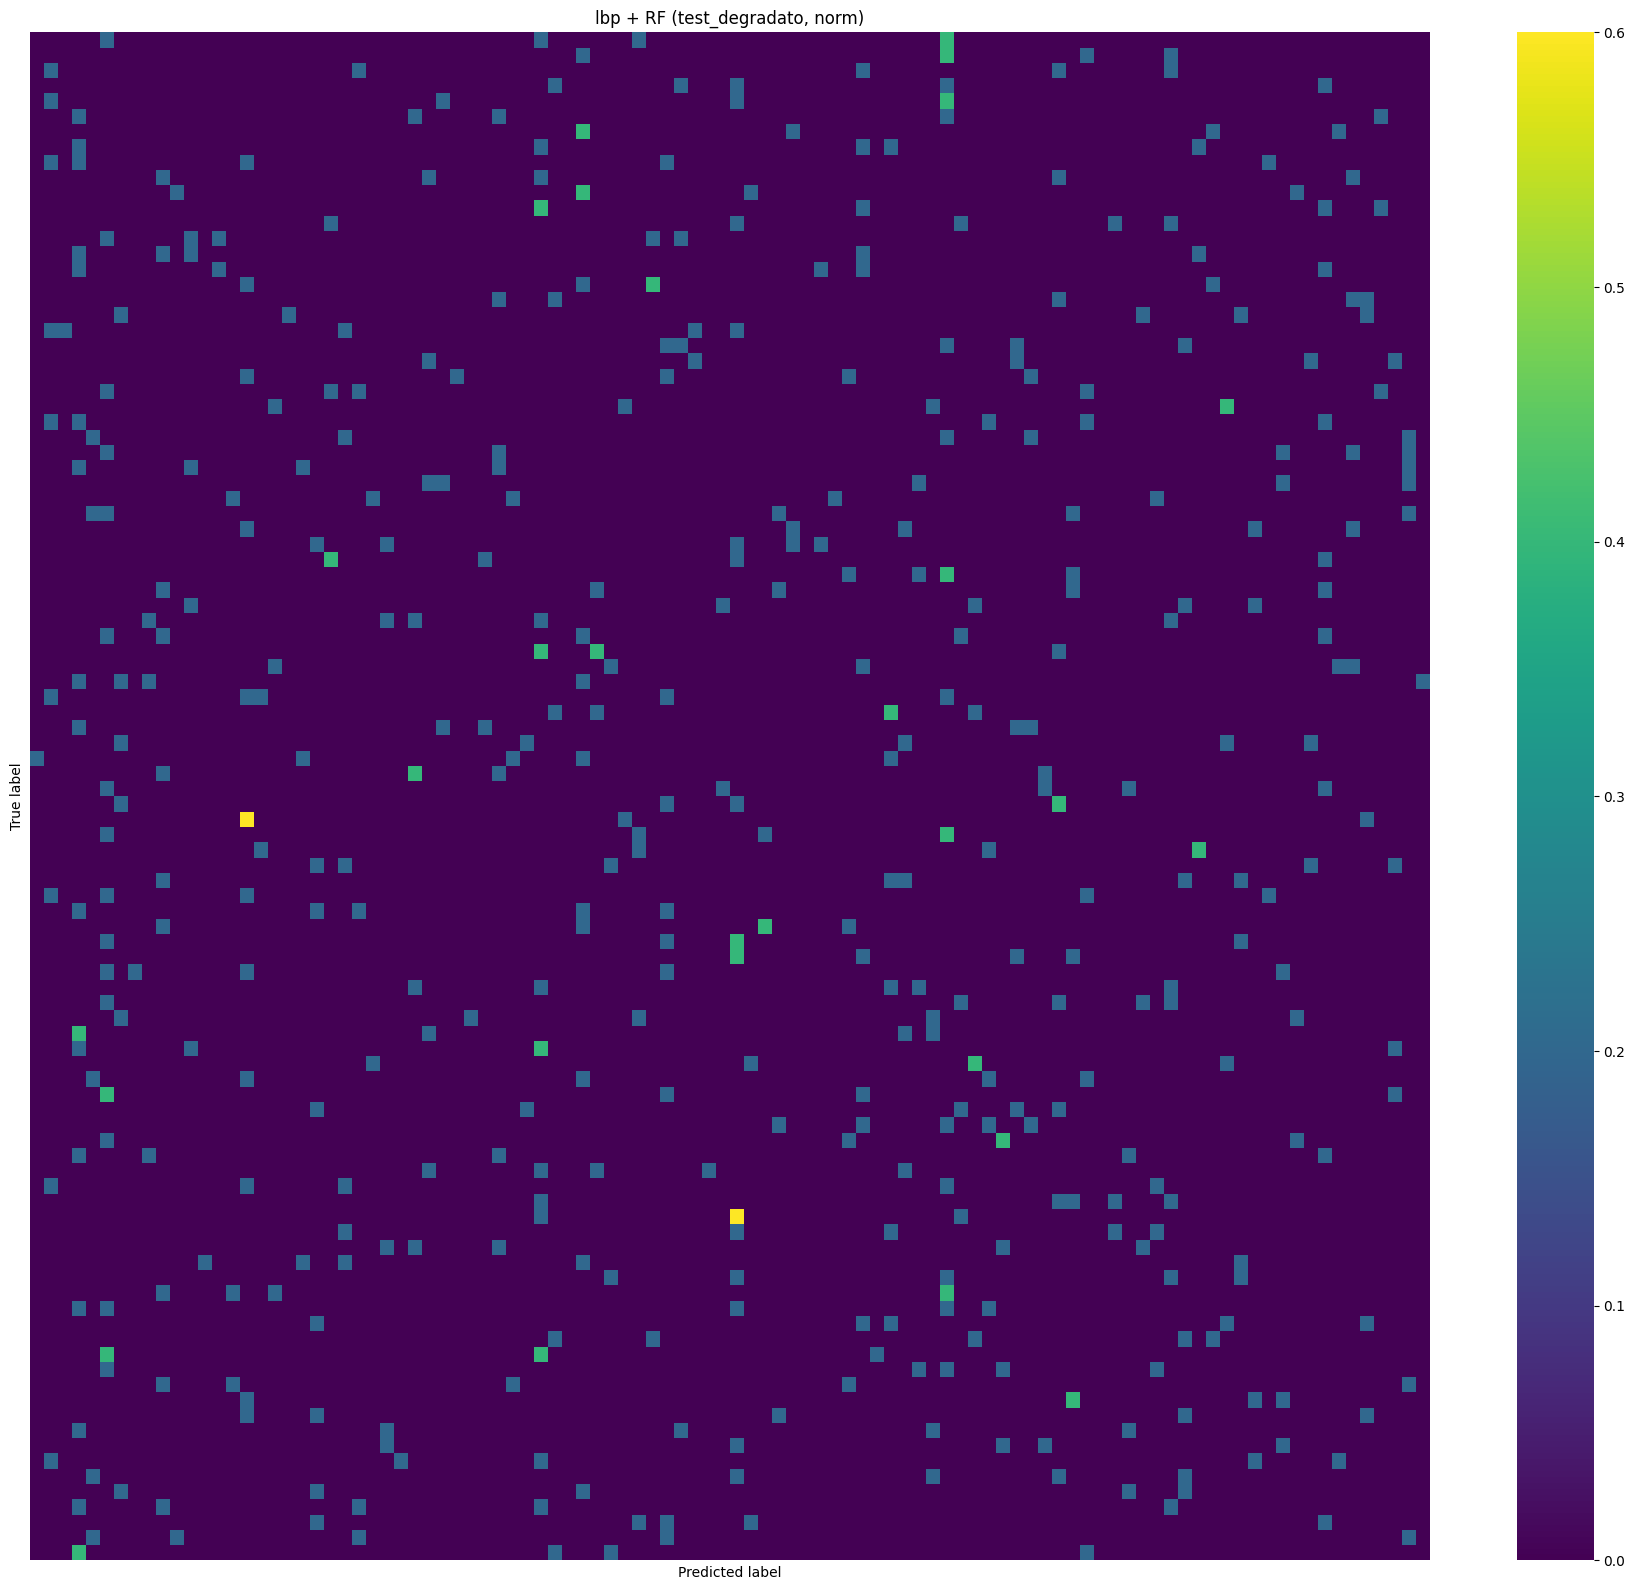


--- MODEL = GNB ---
Best params: {}
Val Macro-F1: 0.0240
TEST Acc:     0.0560
TEST Macro-F1:0.0474


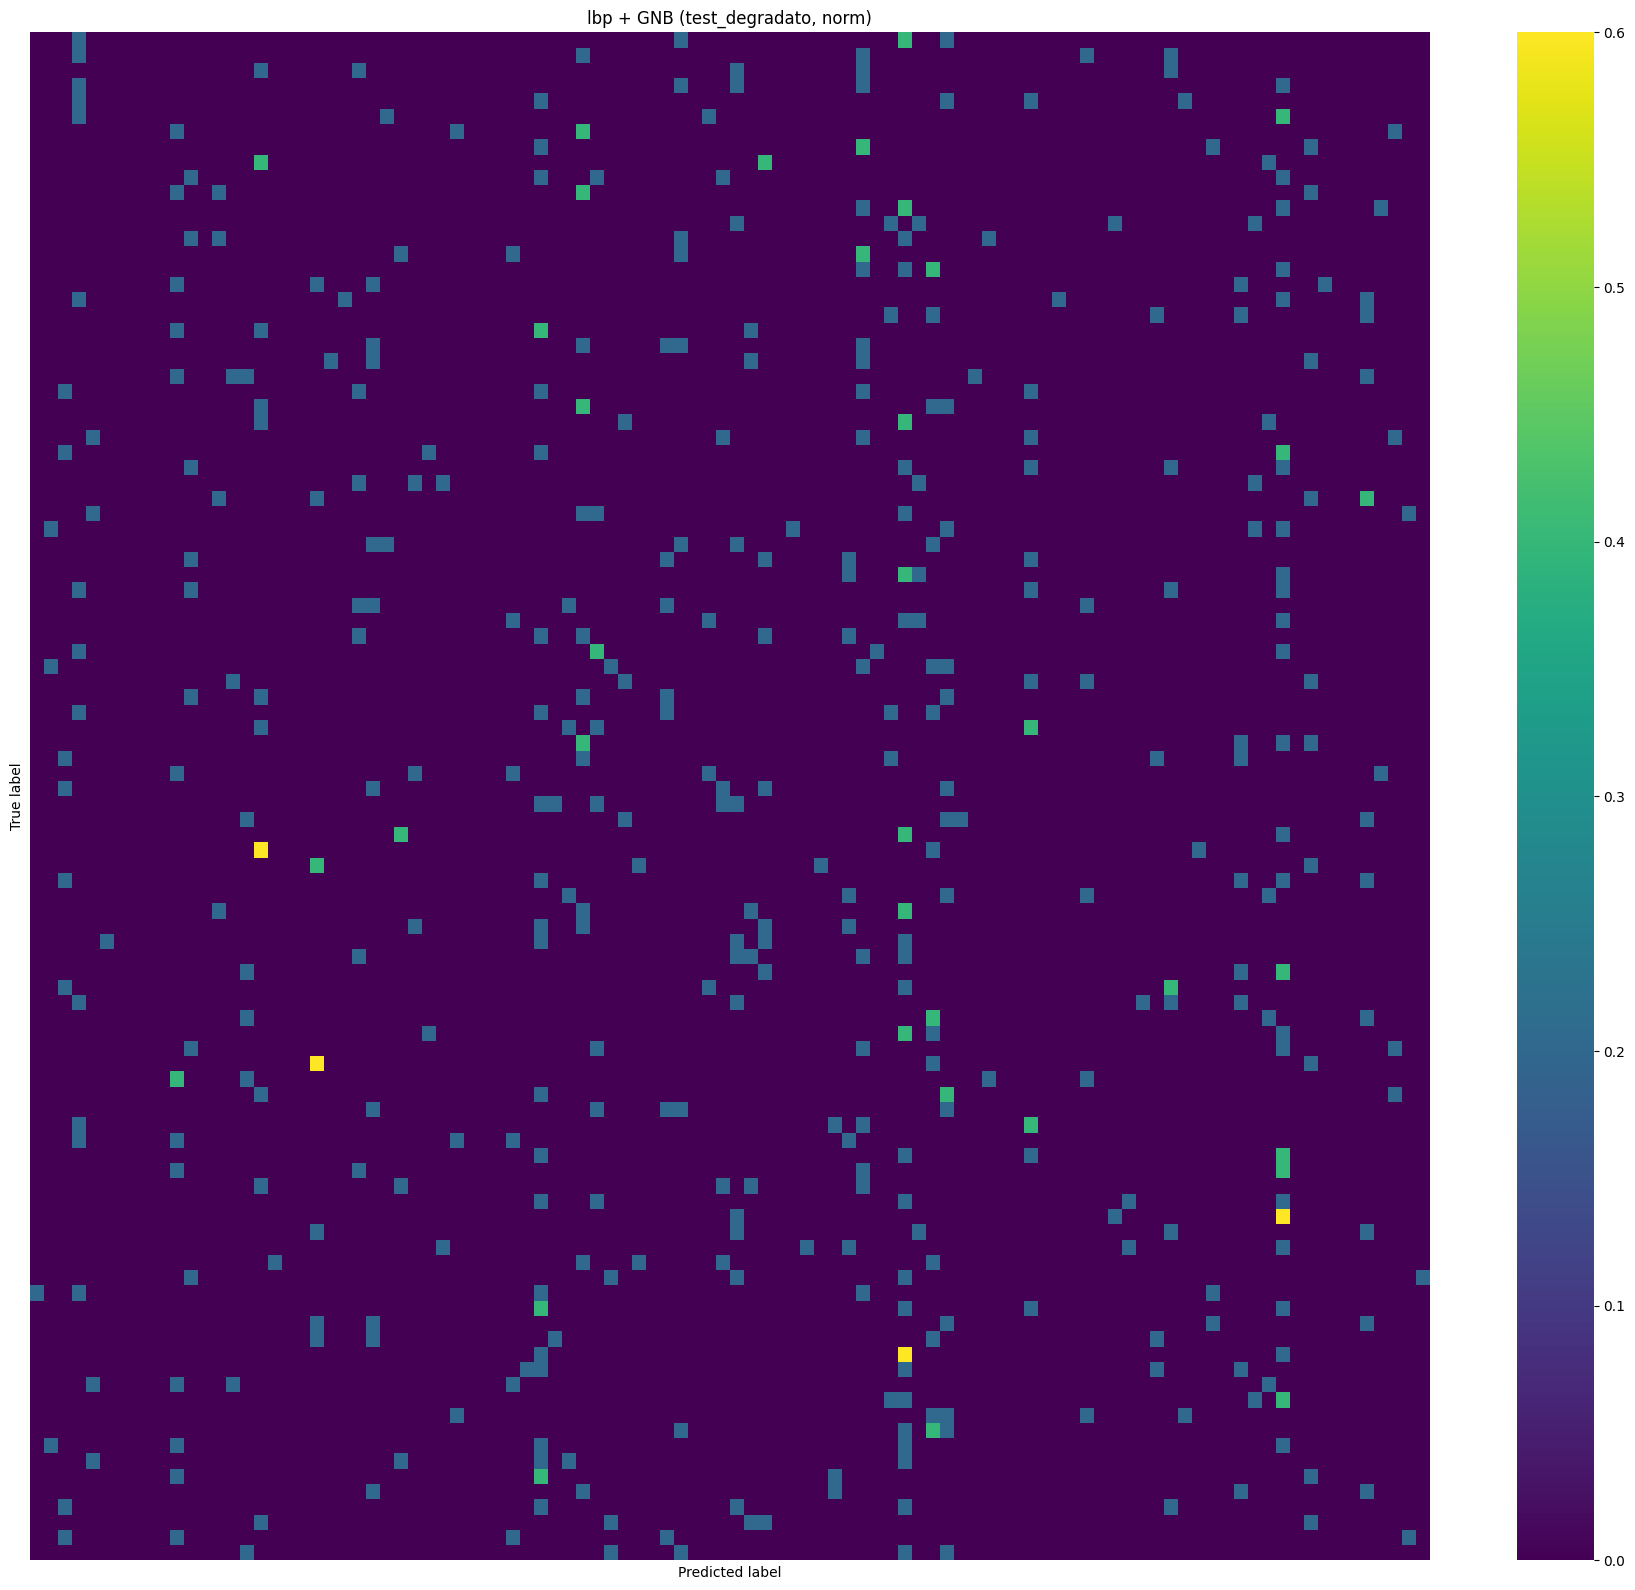


MODE = hog+lbp
[CACHE MISS] calcolo feature per fit hog+lbp...
[CACHE SAVE] fit hog+lbp -> /kaggle/working/feat_cache/Xy_fit_hog+lbp_img128_pre1.npz
[CACHE MISS] calcolo feature per test hog+lbp...
[CACHE SAVE] test hog+lbp -> /kaggle/working/feat_cache/Xy_test_hog+lbp_img128_pre1.npz

--- MODEL = LinearSVC ---
Best params: {'clf__C': 0.1}
Val Macro-F1: 0.0923
TEST Acc:     0.1000
TEST Macro-F1:0.0943


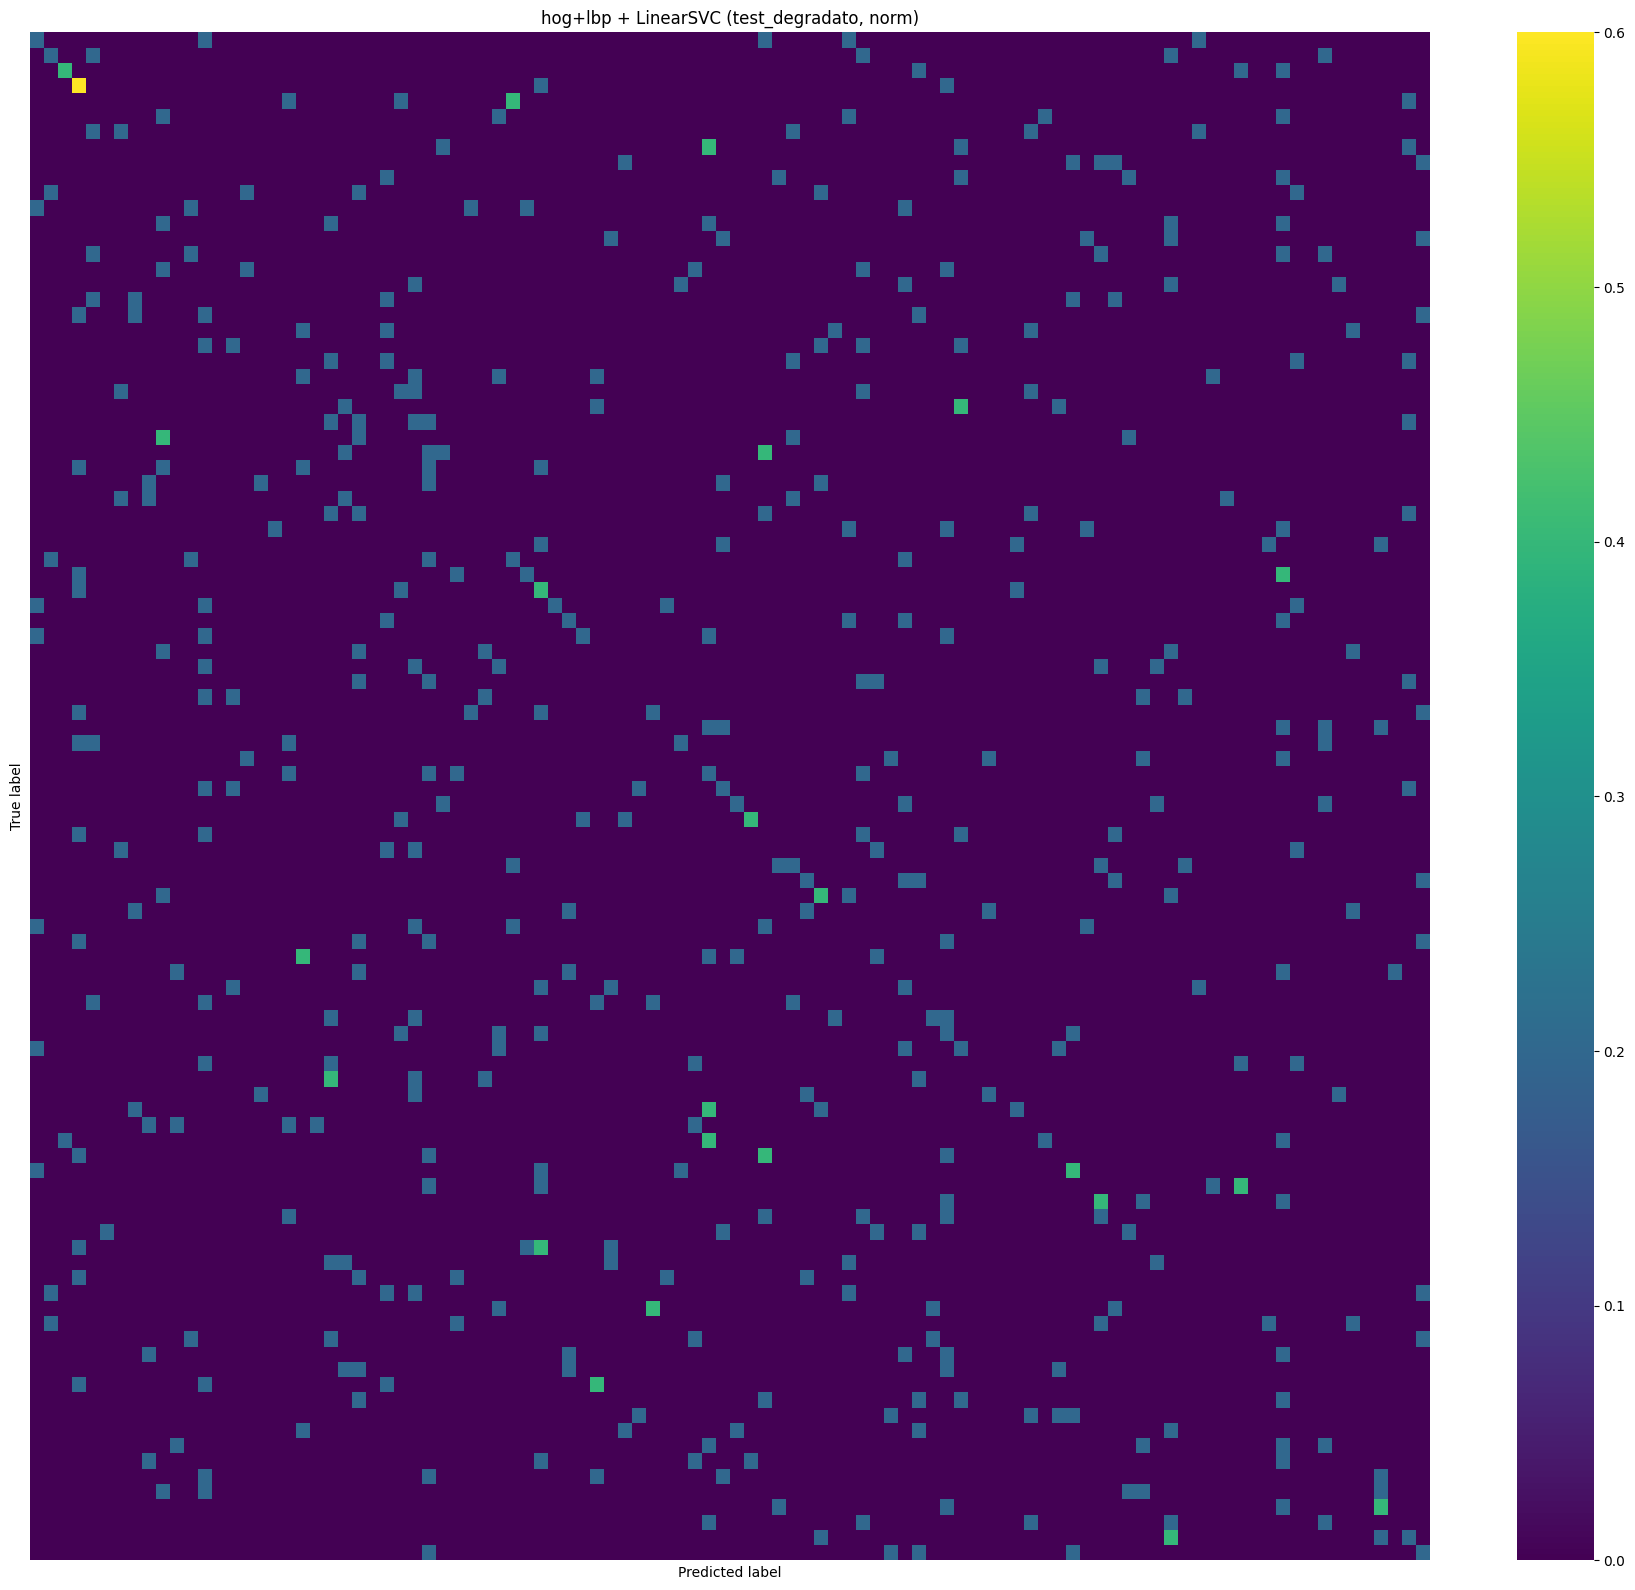


--- MODEL = LogReg ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Best params: {'clf__C': 0.1}
Val Macro-F1: 0.1200
TEST Acc:     0.1520
TEST Macro-F1:0.1503


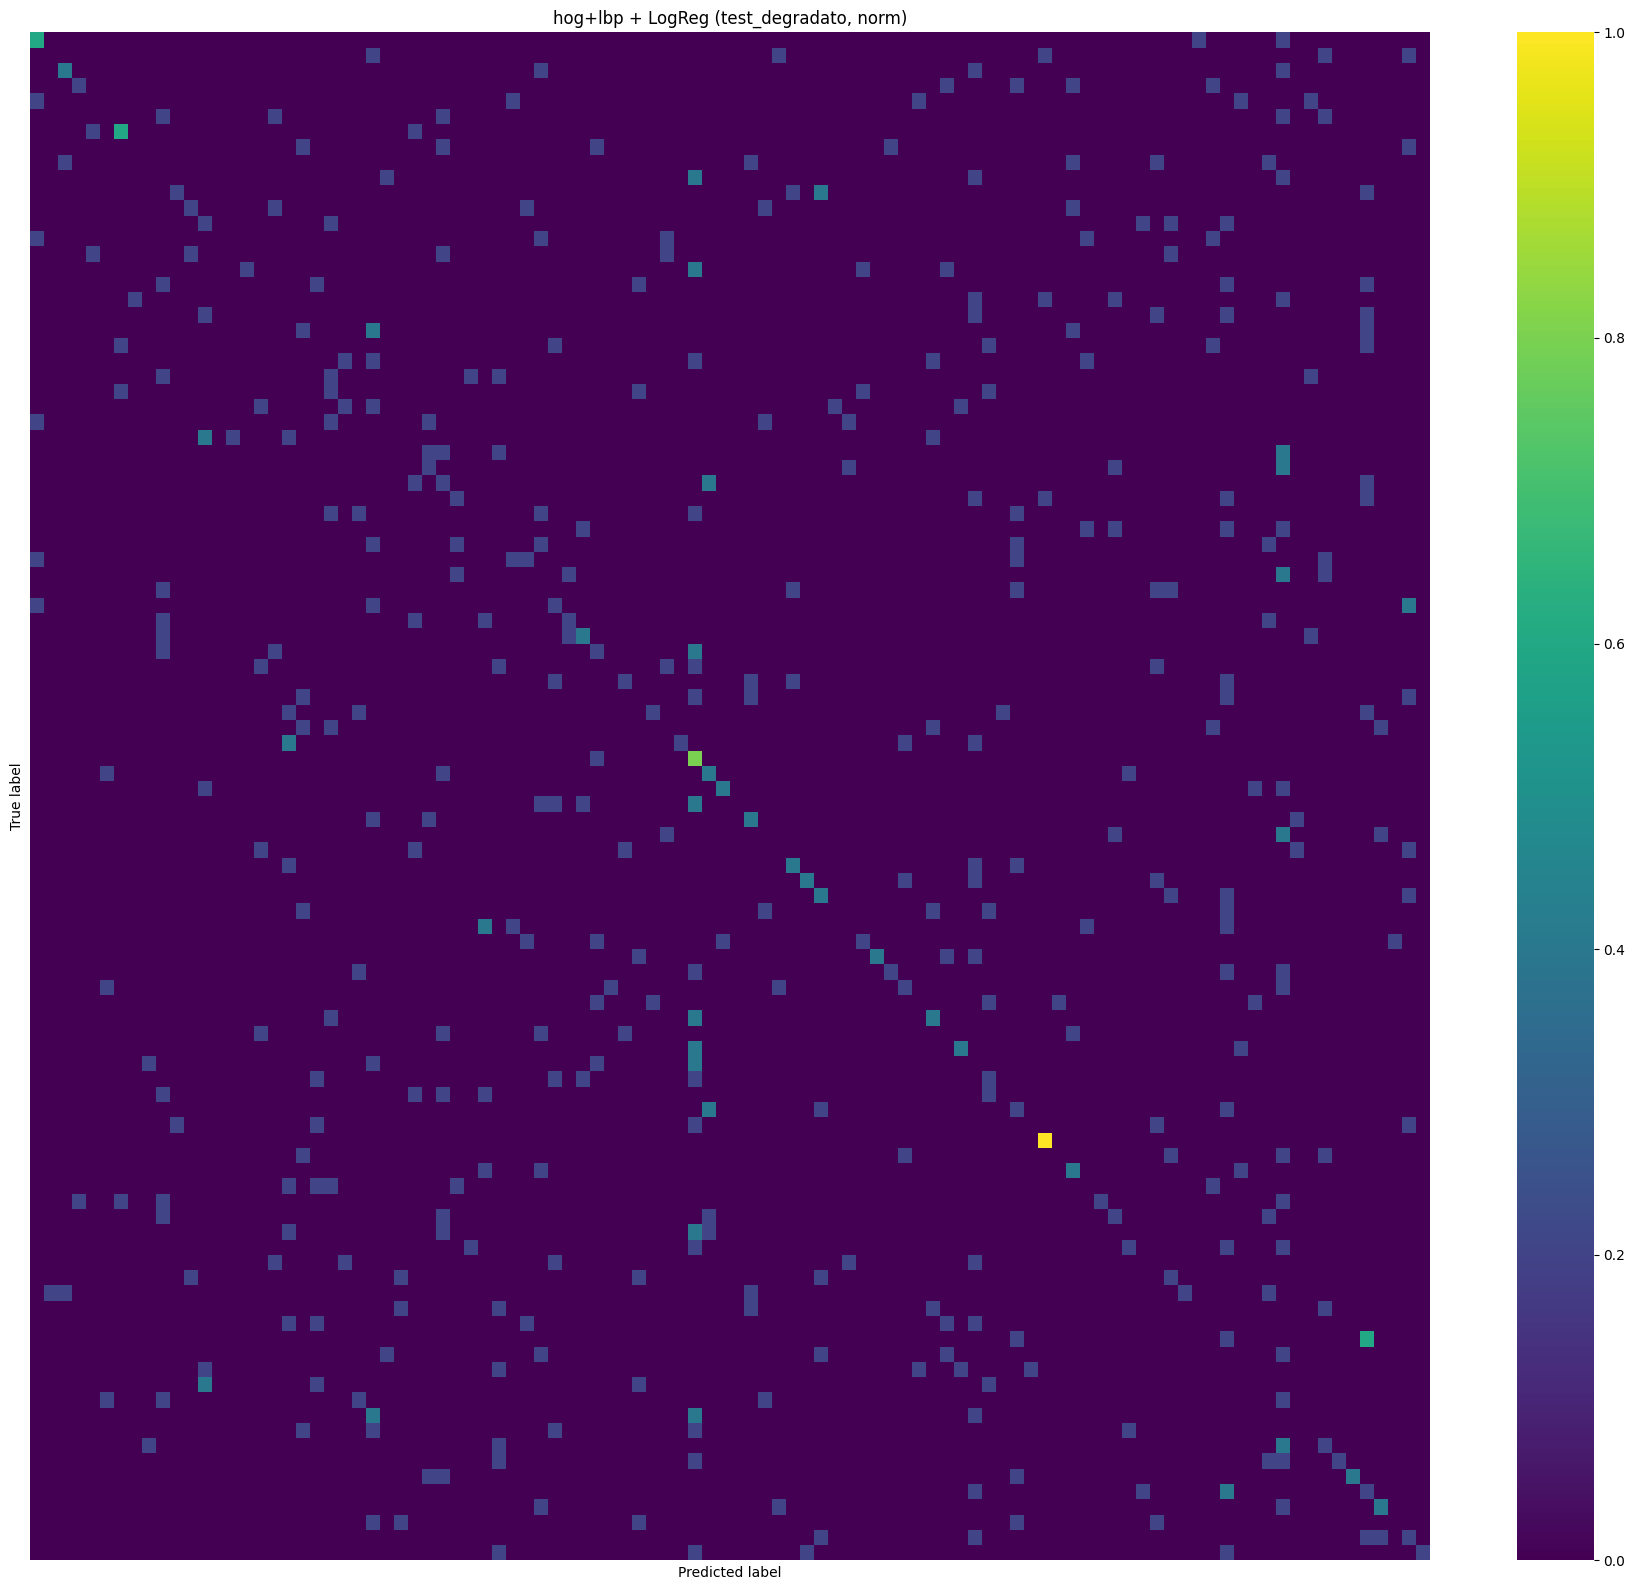


--- MODEL = Ridge ---
Best params: {'clf__alpha': 0.1}
Val Macro-F1: 0.0757
TEST Acc:     0.1020
TEST Macro-F1:0.0991


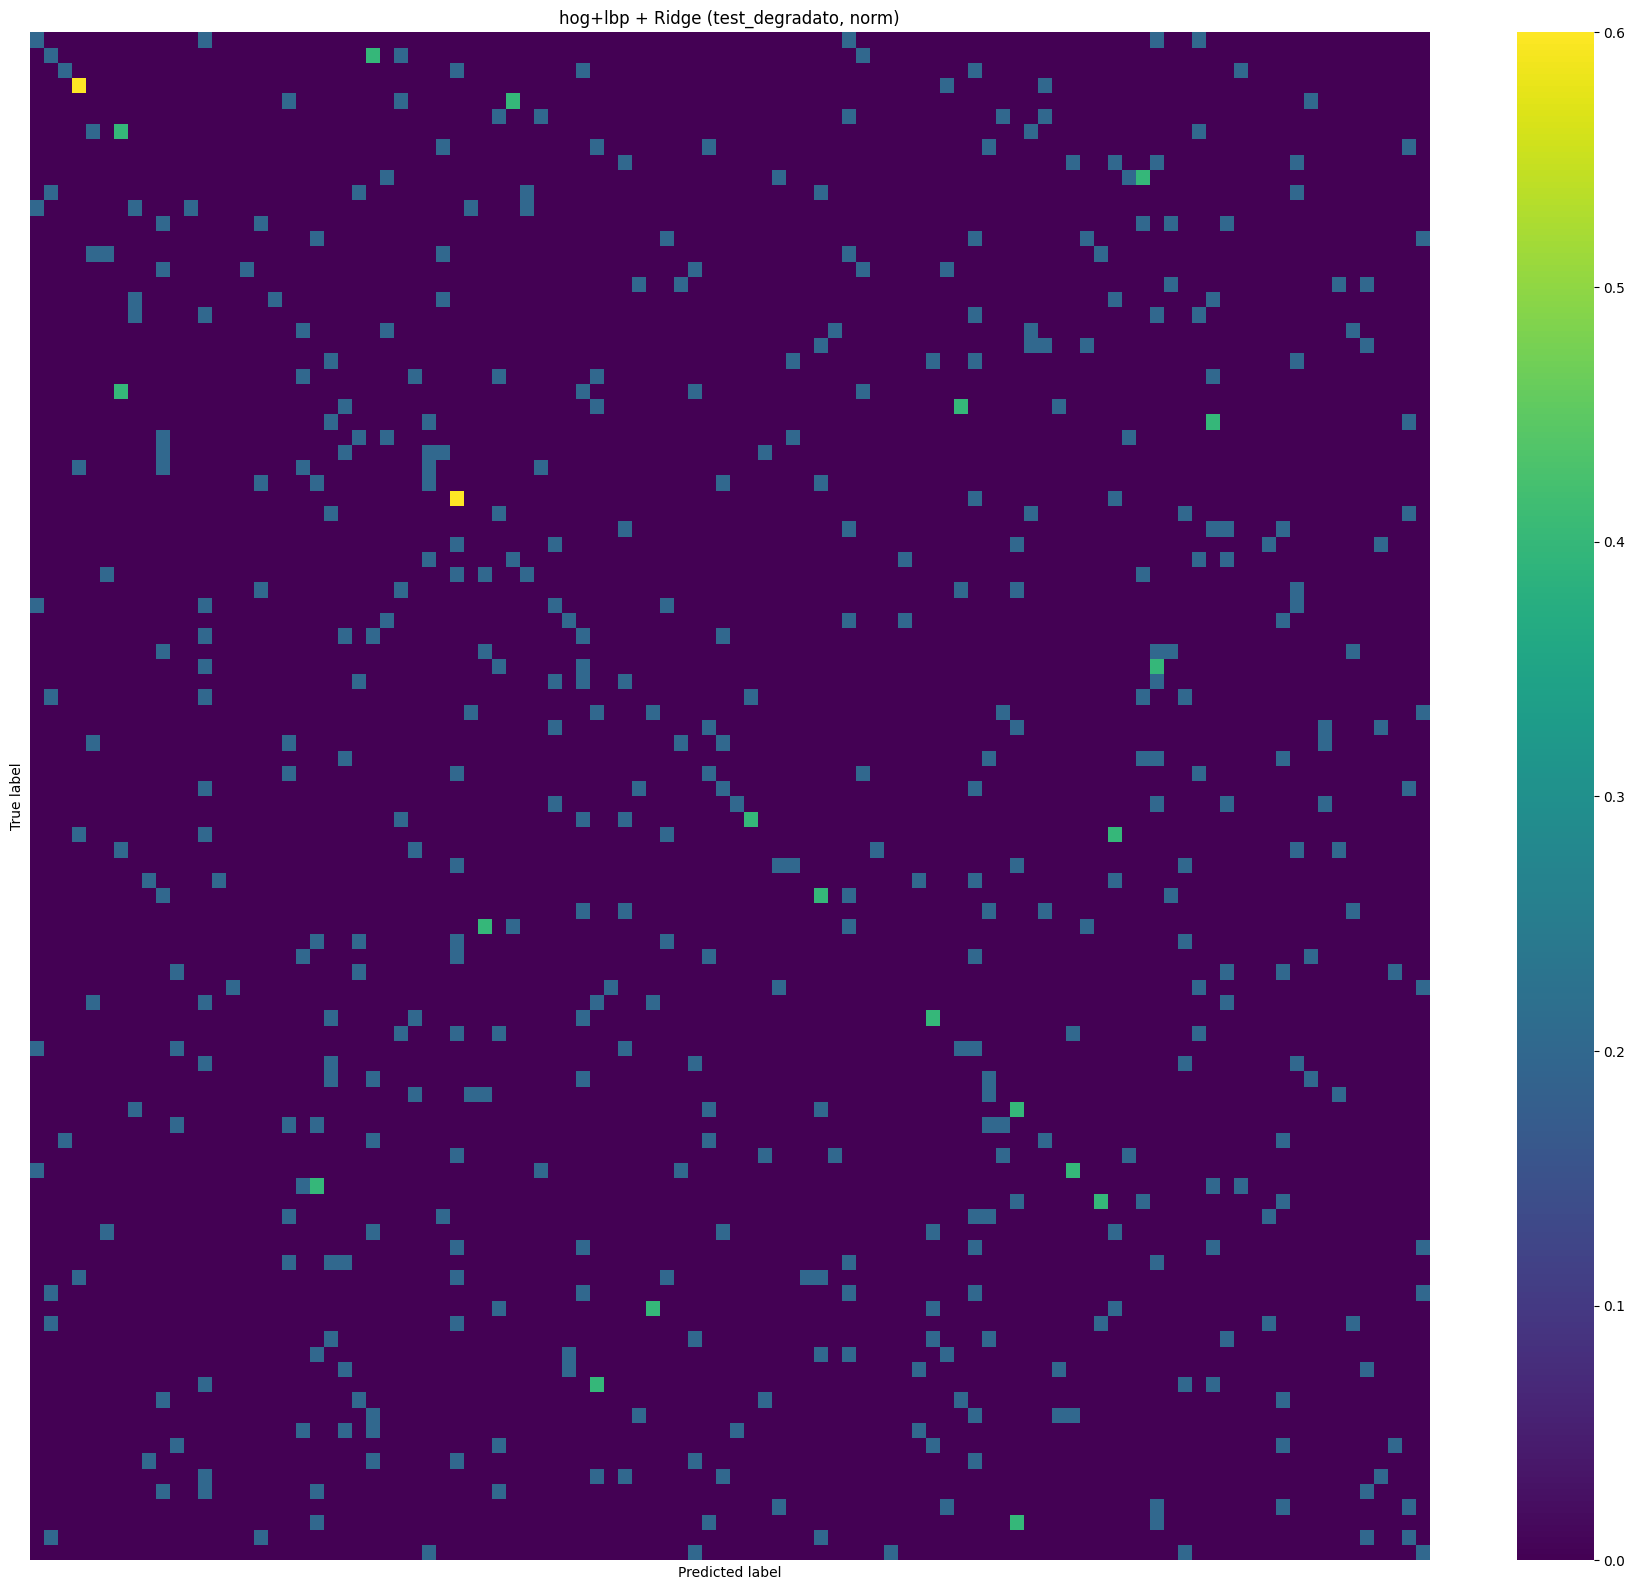


--- MODEL = KNN ---
Best params: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Val Macro-F1: 0.0244
TEST Acc:     0.0520
TEST Macro-F1:0.0364


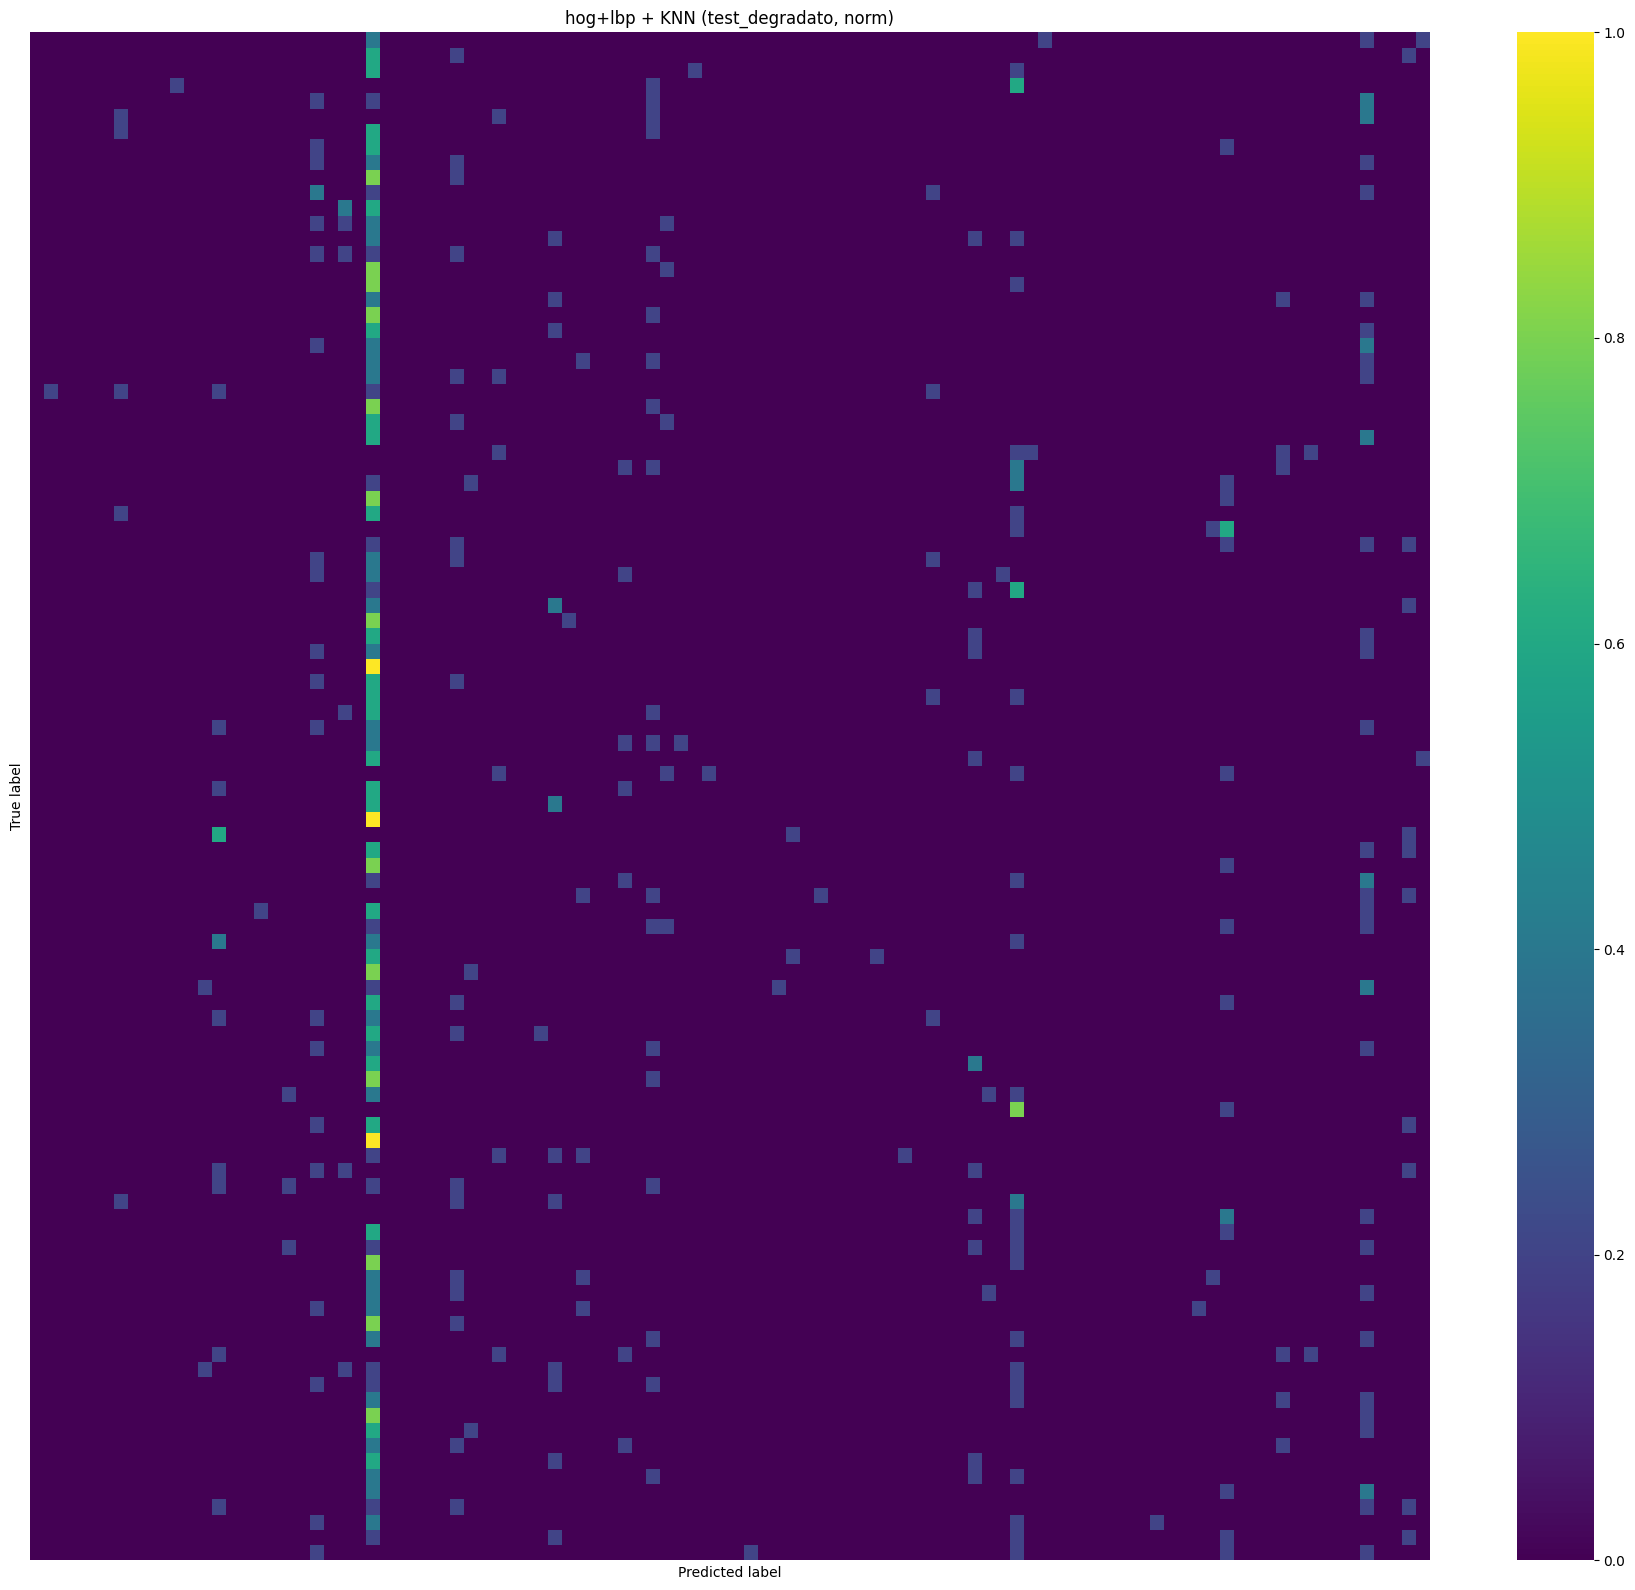


--- MODEL = RF ---
Best params: {'clf__n_estimators': 500, 'clf__max_depth': 40}
Val Macro-F1: 0.0767
TEST Acc:     0.0820
TEST Macro-F1:0.0731


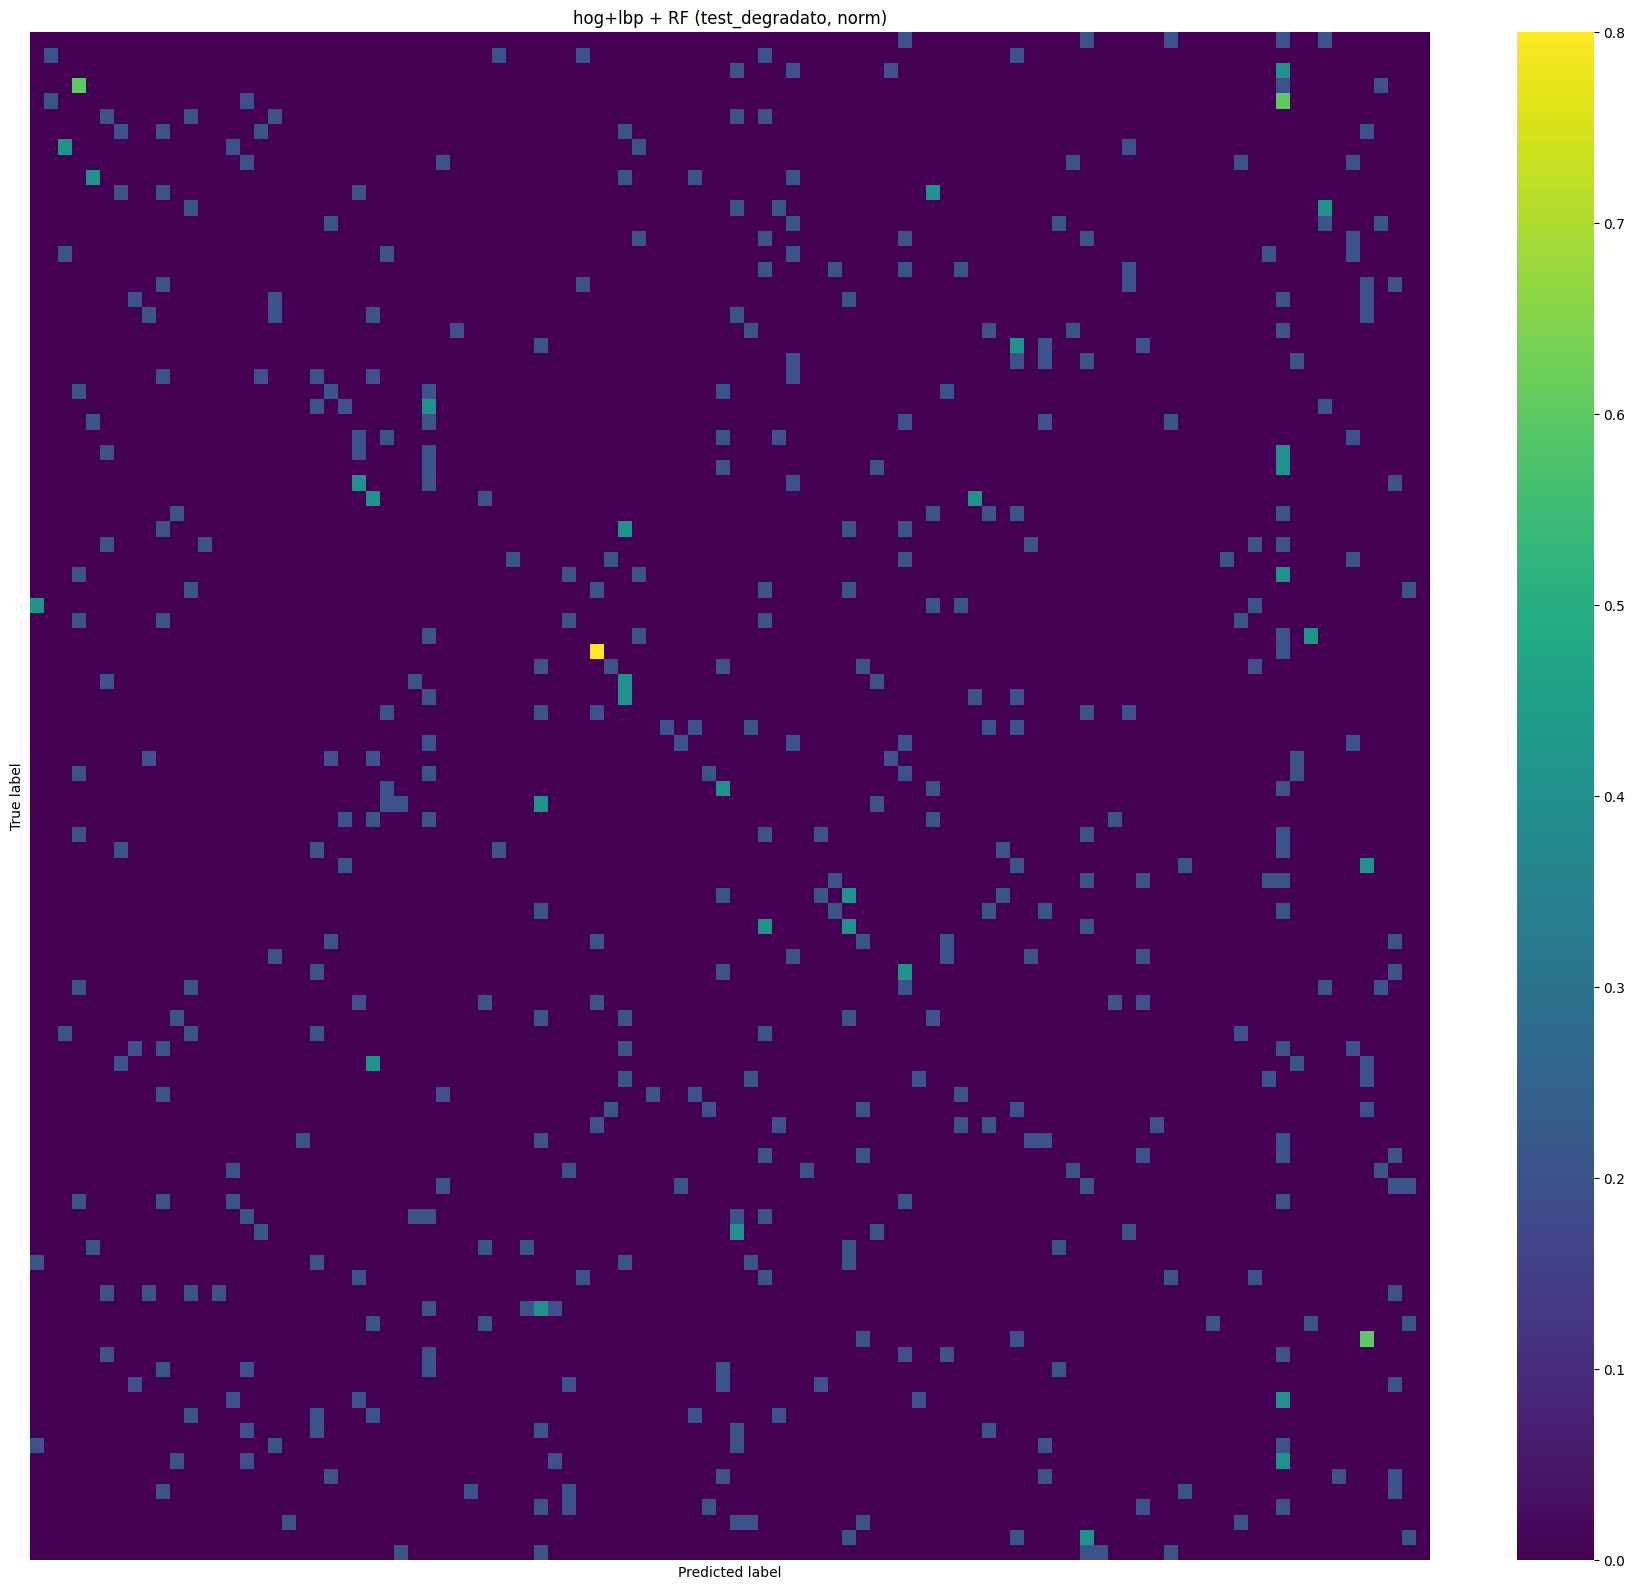


--- MODEL = GNB ---
Best params: {}
Val Macro-F1: 0.0015
TEST Acc:     0.0380
TEST Macro-F1:0.0336


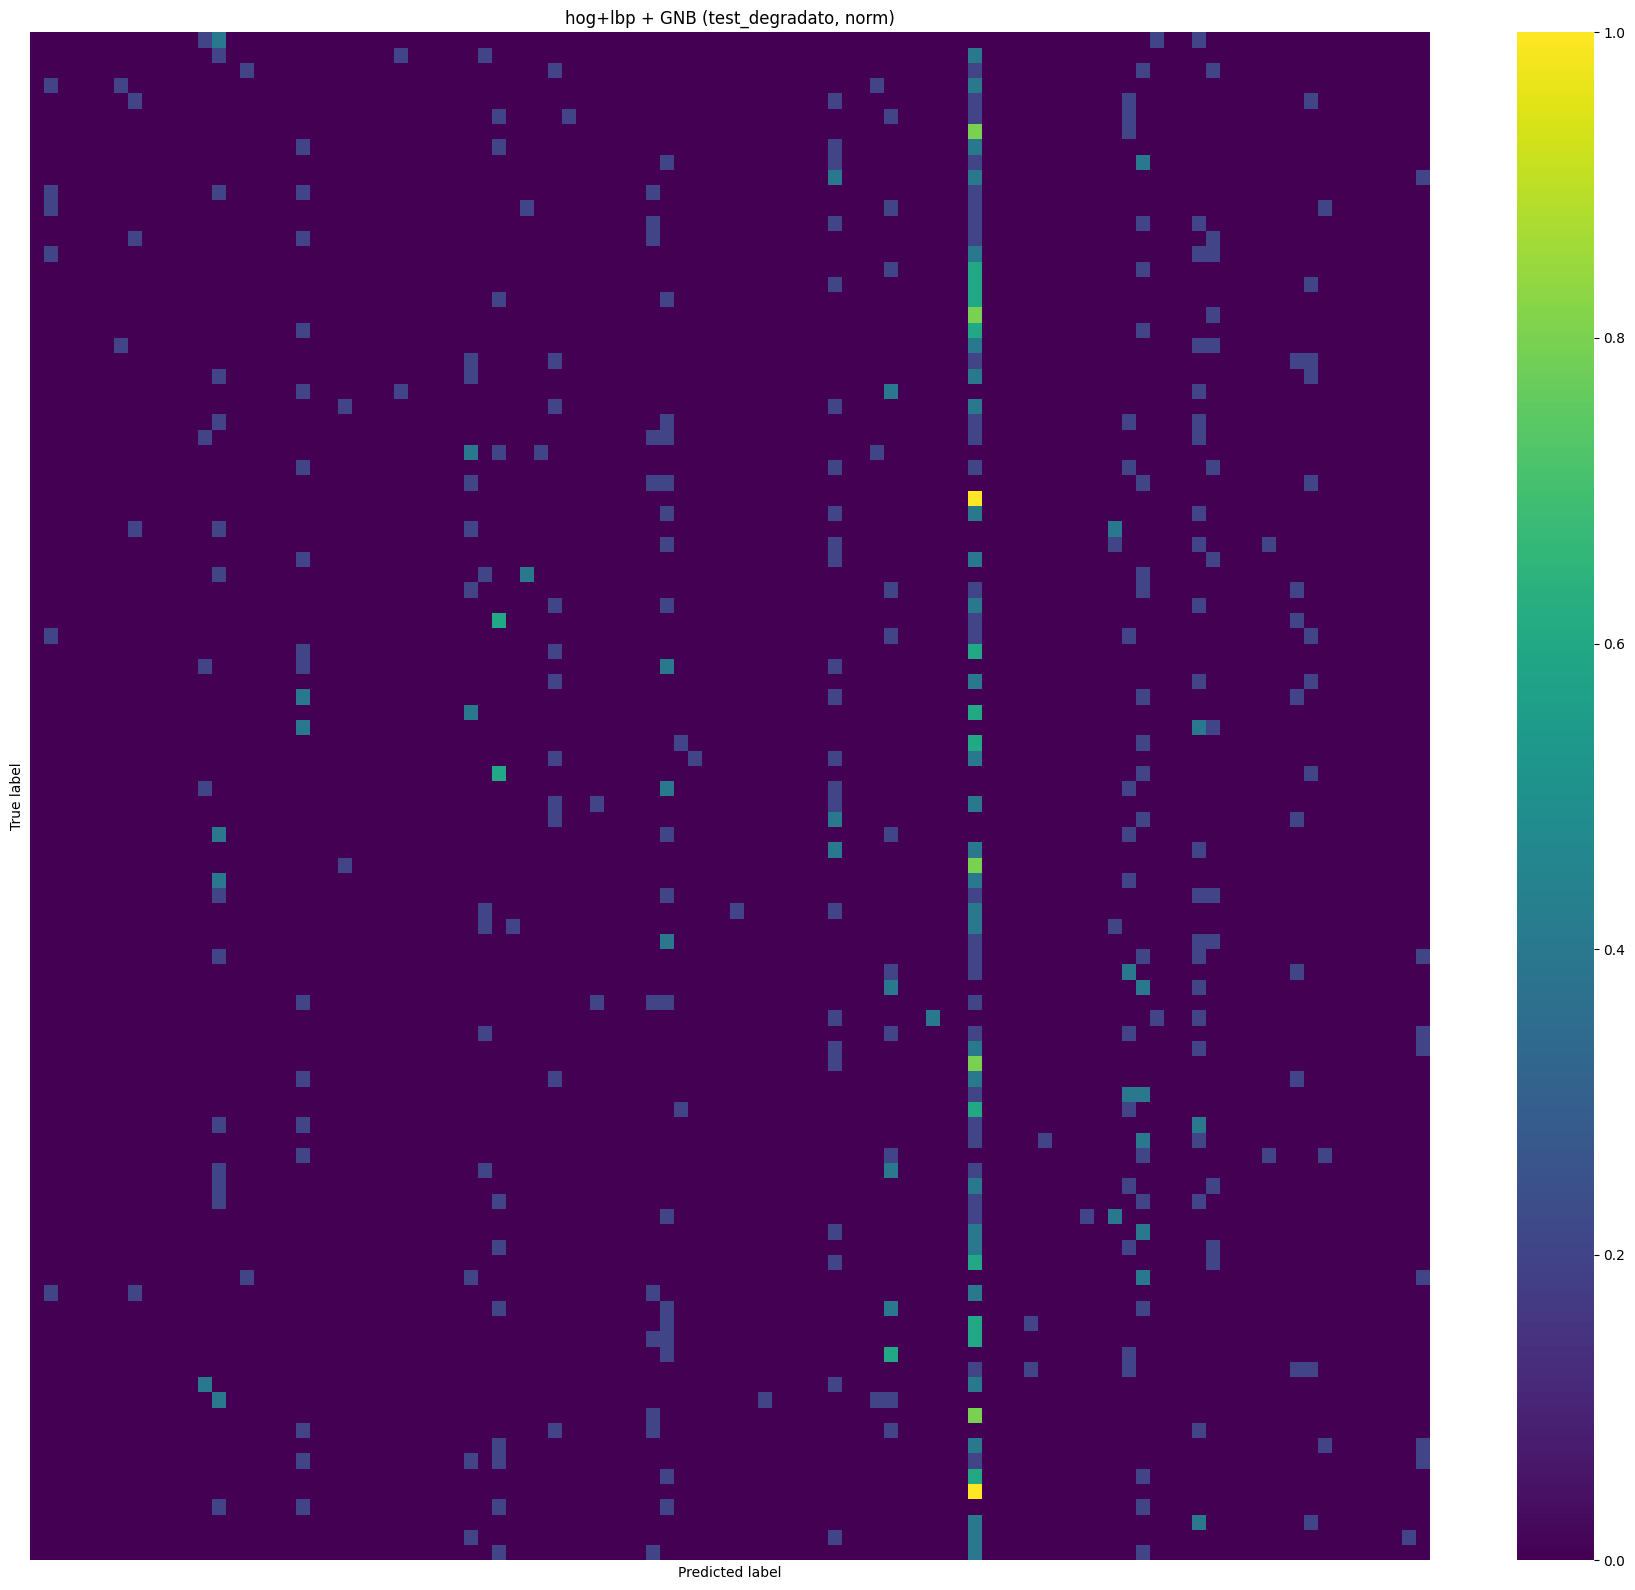

In [22]:
modes = ["hog", "lbp", "hog+lbp"]
models = get_models(cfg)
all_results = {}
cms = {}

for mode in modes:
    print(f"\n====================")
    print(f"MODE = {mode}")
    print(f"====================")

    X_fit, y_fit   = get_or_build_xy(fit_ds,  cfg, mode, split_name="fit")
    X_test, y_test = get_or_build_xy(test_ds, cfg, mode, split_name="test")

    for model_name, (pipe, grid) in models.items():
        print(f"\n--- MODEL = {model_name} ---")
        
        best_params, best_val_f1, test_acc, test_f1, cm, _ = tune_and_test_model(
            X_fit, y_fit, X_test, y_test, cfg, model_name, pipe, grid
        )

        all_results[(mode, model_name)] = (best_params, best_val_f1, test_acc, test_f1)
        cms[(mode, model_name)] = cm

        print("Best params:", best_params)
        print(f"Val Macro-F1: {best_val_f1:.4f}")
        print(f"TEST Acc:     {test_acc:.4f}")
        print(f"TEST Macro-F1:{test_f1:.4f}")

        plot_confusion_matrix(cm, title=f"{mode} + {model_name} (test_degradato, norm)")

In [23]:
print("\n=== RIASSUNTO FINALE ===")
for (mode, model_name), (best_params, best_val_f1, test_acc, test_f1) in all_results.items():
    print(f"{mode:7} | {model_name:8} | ValF1={best_val_f1:.4f} | TestAcc={test_acc:.4f} | TestF1={test_f1:.4f} | {best_params}")



=== RIASSUNTO FINALE ===
hog     | LinearSVC | ValF1=0.0923 | TestAcc=0.0980 | TestF1=0.0905 | {'clf__C': 0.1}
hog     | LogReg   | ValF1=0.1200 | TestAcc=0.1500 | TestF1=0.1476 | {'clf__C': 0.1}
hog     | Ridge    | ValF1=0.0757 | TestAcc=0.1020 | TestF1=0.0970 | {'clf__alpha': 0.1}
hog     | KNN      | ValF1=0.0244 | TestAcc=0.0540 | TestF1=0.0371 | {'clf__n_neighbors': 3, 'clf__weights': 'distance'}
hog     | RF       | ValF1=0.0700 | TestAcc=0.0660 | TestF1=0.0546 | {'clf__n_estimators': 500, 'clf__max_depth': 40}
hog     | GNB      | ValF1=0.0015 | TestAcc=0.0400 | TestF1=0.0350 | {}
lbp     | LinearSVC | ValF1=0.0362 | TestAcc=0.0480 | TestF1=0.0330 | {'clf__C': 3.0}
lbp     | LogReg   | ValF1=0.0533 | TestAcc=0.0560 | TestF1=0.0485 | {'clf__C': 10.0}
lbp     | Ridge    | ValF1=0.0170 | TestAcc=0.0440 | TestF1=0.0207 | {'clf__alpha': 1.0}
lbp     | KNN      | ValF1=0.0600 | TestAcc=0.0480 | TestF1=0.0449 | {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
lbp     | RF       | 

In [24]:
for (mode, model_name), cm in cms.items():
    print(f"\n=== Top confusions: {mode} + {model_name} ===")
    print_top_confusions(cm, class_names, top_k=30)


=== Top confusions: hog + LinearSVC ===

Top 30 coppie più confuse:

axe throwing → gaga  | 2 errori
baseball → ice yachting  | 2 errori
disc golf → rings  | 2 errori
field hockey → baton twirling  | 2 errori
figure skating men → judo  | 2 errori
giant slalom → trapeze  | 2 errori
rowing → ice yachting  | 2 errori
sailboat racing → ice yachting  | 2 errori
shot put → judo  | 2 errori
sidecar racing → table tennis  | 2 errori
snow boarding → golf  | 2 errori
sumo wrestling → horseshoe pitching  | 2 errori
track bicycle → high jump  | 2 errori
water cycling → jai alai  | 2 errori
wheelchair racing → speed skating  | 2 errori
air hockey → bmx  | 1 errori
air hockey → judo  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → sumo wrestling  | 1 errori
ampute football → axe throwing  | 1 errori
ampute football → olympic wrestling  | 1 errori
ampute football → speed skating  | 1 errori
ampute football → uneven bars  | 1 errori
archery → pole vault  | 1 errori
archery → table tenn